## $Z^*$ known

### Training Steps

In [57]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

from experiments import generate_data
from metrics import mcc, corr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def pairwise_corr(z, z_):
    return np.mean([corr(a, b)[0] for a, b in zip(z.T, z_.T)])

def cossim(z, z_):
    return -F.cosine_similarity(z.T, z_.T).mean()

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    criterion = cossim
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_ = model(X_train)
        loss = criterion(S_train, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(pairwise_corr(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_ = model(X_test)
                loss = criterion(S_test, S_)
            log['loss_test'].append(loss.item())
            log['mcc_test'].append(pairwise_corr(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy()))
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0)
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256, 1024]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i
    
    SAE = nn.Sequential(nn.Linear(M, N), nn.ReLU()).to(device)
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        MLP = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU()).to(device)
        logs_mlps[h].append(run_experiment(MLP, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "MLPs": avg_mlps
}

# New function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_training_steps.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

ImportError: cannot import name 'GatedSAE' from 'models' (/Users/charlesoneill/sparse-inference/experiments/models.py)

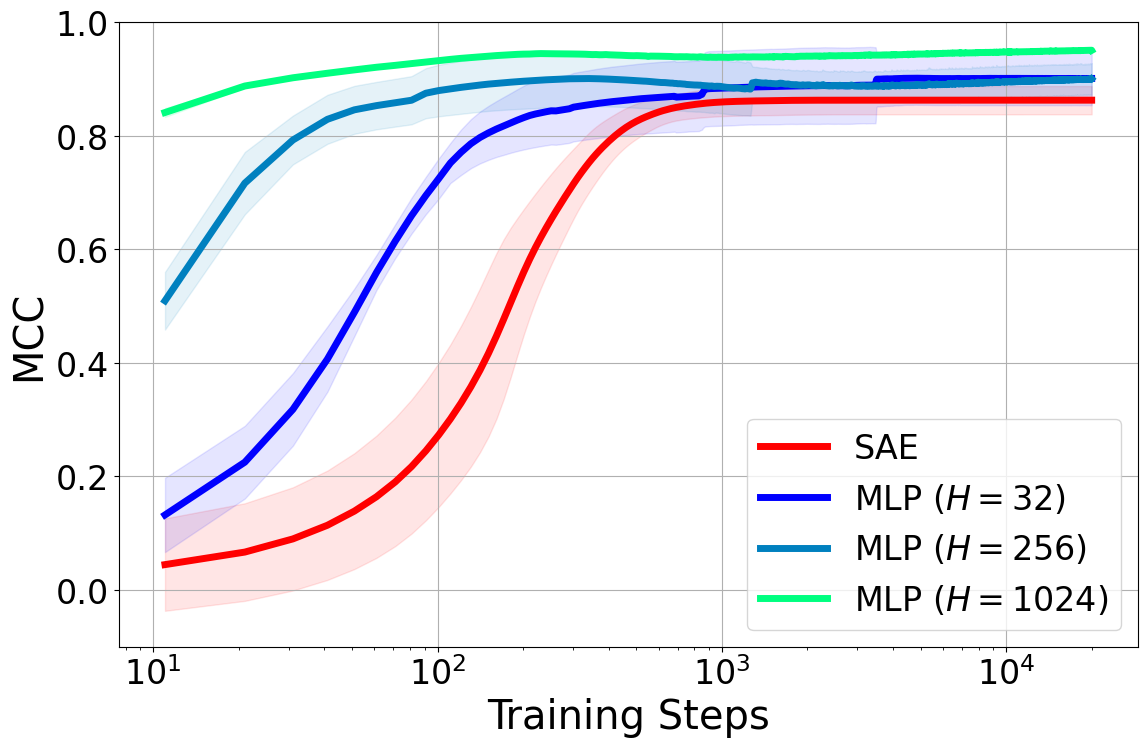

In [17]:
# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-', 
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1, 
                 avg_sae['mcc_test'] - avg_sae['mcc_test_std'], 
                 avg_sae['mcc_test'] + avg_sae['mcc_test_std'], 
                 alpha=alpha, color='red')

colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-', 
             color=color, label=f'MLP ($H={h}$)', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1, 
                     avg_mlp['mcc_test'] - avg_mlp['mcc_test_std'], 
                     avg_mlp['mcc_test'] + avg_mlp['mcc_test_std'], 
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_D_training_steps.pdf', dpi=300, bbox_inches='tight')
plt.show()

### FLOPs

In [14]:
def calculate_sae_inference_flops(M, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # Linear layer FLOPs
    linear_flops = (2 * M * N)  # includes matrix multiplication and bias addition
    
    # ReLU activation FLOPs
    relu_flops = N  # one comparison per output neuron
    
    # Total FLOPs for one sample
    flops_per_sample = linear_flops + relu_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_sae_training_flops(M, N, num_samples, num_steps, batch_size=None):
    """
    Calculate the number of FLOPs for training an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_sae_inference_flops(M, N, 1)
    
    # Backward pass FLOPs
    relu_grad_flops = N  # ReLU gradient
    linear_grad_flops = (2 * N * M) + N  # Linear layer gradient
    weight_update_flops = 2 * (M * N + N)  # Weight update
    
    backward_flops = relu_grad_flops + linear_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

# Example usage:
M, N = 8, 16
num_samples = 1024
num_steps = 20000

inference_flops = calculate_sae_inference_flops(M, N, num_samples)
training_flops = calculate_sae_training_flops(M, N, num_samples, num_steps)

print(f"Inference FLOPs: {inference_flops}")
print(f"Training FLOPs: {training_flops}")

Inference FLOPs: 278528
Training FLOPs: 17367040000


In [15]:
def calculate_mlp_inference_flops(M, h, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # First Linear layer FLOPs
    linear1_flops = 2 * M * h
    
    # First ReLU activation FLOPs
    relu1_flops = h
    
    # Second Linear layer FLOPs
    linear2_flops = 2 * h * N
    
    # Second ReLU activation FLOPs
    relu2_flops = N
    
    # Total FLOPs for one sample
    flops_per_sample = linear1_flops + relu1_flops + linear2_flops + relu2_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_mlp_training_flops(M, h, N, num_samples, num_steps, batch_size=None):
    """
    Calculate the number of FLOPs for training an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_mlp_inference_flops(M, h, N, 1)
    
    # Backward pass FLOPs
    relu2_grad_flops = N
    linear2_grad_flops = (2 * N * h) + N
    relu1_grad_flops = h
    linear1_grad_flops = (2 * M * h) + h
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * h + h + h * N + N)
    
    # Total backward pass FLOPs
    backward_flops = relu2_grad_flops + linear2_grad_flops + relu1_grad_flops + linear1_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_training_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    # Total FLOPs for testing (inference on test set)
    total_testing_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    
    # Grand total FLOPs
    grand_total_flops = total_training_flops + total_testing_flops
    
    return grand_total_flops

# Example usage:
M, N = 8, 16
hidden_layers = [32, 256, 1024]
num_samples = 1024
num_steps = 20000

for h in hidden_layers:
    inference_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    training_flops = calculate_mlp_training_flops(M, h, N, num_samples, num_steps)
    print(f"Hidden layer size: {h}")
    print(f"Inference FLOPs: {inference_flops}")
    print(f"Total Training + Testing FLOPs: {training_flops}")
    print()

Hidden layer size: 32
Inference FLOPs: 1622016
Total Training + Testing FLOPs: 99288662016

Hidden layer size: 256
Inference FLOPs: 12861440
Total Training + Testing FLOPs: 782840381440

Hidden layer size: 1024
Inference FLOPs: 51396608
Total Training + Testing FLOPs: 3126446276608



In [20]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc, corr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def pairwise_corr(z, z_):
    return np.mean([corr(a, b)[0] for a, b in zip(z.T, z_.T)])

def cossim(z, z_):
    return -F.cosine_similarity(z.T, z_.T).mean()

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    criterion = cossim
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    # Calculate initial FLOPs
    if isinstance(model, nn.Sequential) and len(model) == 2:  # SAE
        total_flops = calculate_sae_training_flops(M, N, num_data, 0)  # 0 steps initially
    else:  # MLP
        h = model[0].out_features
        total_flops = calculate_mlp_training_flops(M, h, N, num_data, 0)  # 0 steps initially
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_ = model(X_train)
        loss = criterion(S_train, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(pairwise_corr(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_ = model(X_test)
                loss = criterion(S_test, S_)
            log['loss_test'].append(loss.item())
            log['mcc_test'].append(pairwise_corr(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            # Calculate and log total FLOPs up to this point
            if isinstance(model, nn.Sequential) and len(model) == 2:  # SAE
                total_flops = calculate_sae_training_flops(M, N, num_data, i+1)
            else:  # MLP
                h = model[0].out_features
                total_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1)
            log['flops'].append(total_flops)
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'flops': logs[0]['flops']  # FLOPs are deterministic, so we can just take the first run
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256, 1024]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i
    
    SAE = nn.Sequential(nn.Linear(M, N), nn.ReLU()).to(device)
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        MLP = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU()).to(device)
        logs_mlps[h].append(run_experiment(MLP, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_flops.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/fixed_Z_flops.json'.")

Running experiments: 100%|██████████| 5/5 [14:32<00:00, 174.55s/it]

Experiment completed. Results saved to 'results/fixed_Z_flops.json'.


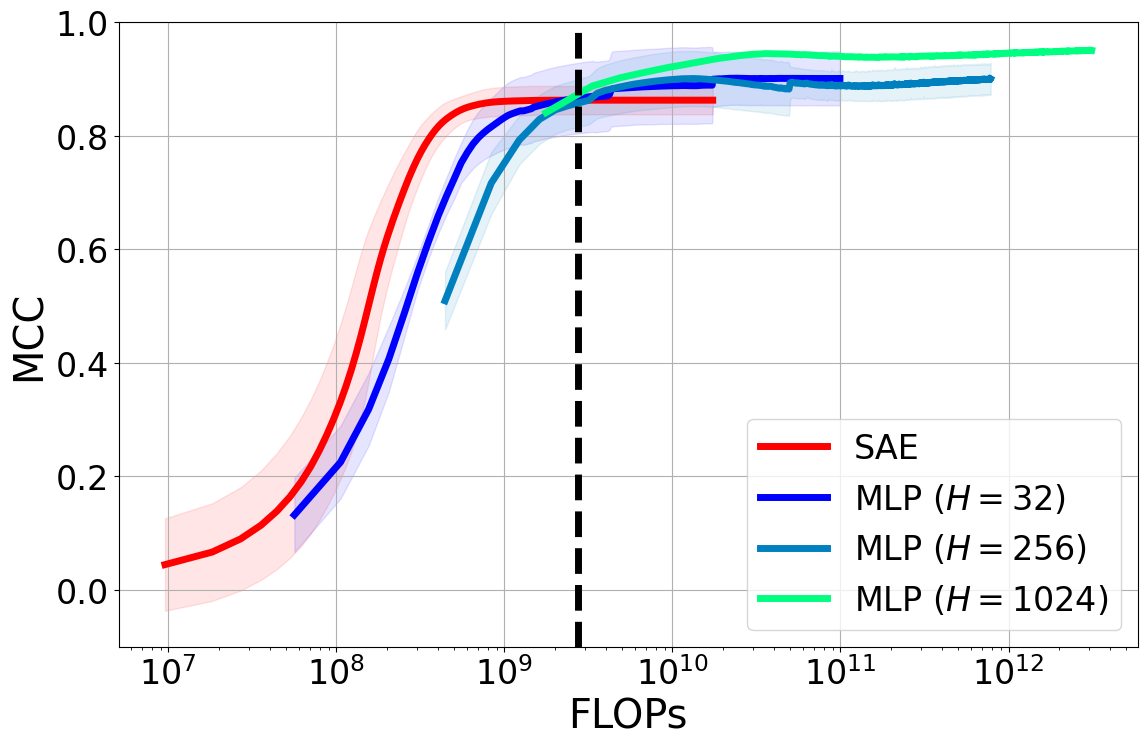

Average crossover point: 2.73e+09 FLOPs


In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_Z_training_steps_and_flops.json', 'r') as f:
    data = json.load(f)

# Function to find crossover point
def find_crossover(sae_flops, sae_mcc, mlp_flops, mlp_mcc):
    for i in range(1, len(mlp_mcc)):
        if mlp_mcc[i-1] <= sae_mcc[-1] and mlp_mcc[i] > sae_mcc[-1]:
            return (mlp_flops[i-1] + mlp_flops[i]) / 2
    return None

# Calculate crossover points
sae_flops = np.array(data['SAE']['flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])

crossover_points = []
for h, mlp_data in data['MLPs'].items():
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    crossover = find_crossover(sae_flops, sae_mcc, mlp_flops, mlp_mcc)
    if crossover is not None:
        crossover_points.append(crossover)

average_crossover = np.mean(crossover_points) if crossover_points else None

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP ($H={h}$)', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)

# Plot average crossover line
if average_crossover:
    plt.axvline(x=average_crossover, color='black', linestyle='--', linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_Z_flops.pdf', dpi=300, bbox_inches='tight')
plt.show()

if average_crossover:
    print(f"Average crossover point: {average_crossover:.2e} FLOPs")
else:
    print("No crossover points found")

## Fixed $D^*$

In [7]:
def calculate_sparse_coding_inference_flops(M, N, num_samples, learn_D=False):
    """
    Calculate the number of FLOPs for inference in SparseCoding.
    
    Args:
    M (int): Number of measurements
    N (int): Number of sparse sources
    num_samples (int): Number of samples to perform inference on
    learn_D (bool): Whether D is being learned or not
    
    Returns:
    int: Total number of FLOPs for inference
    """
    flops = 0
    
    if learn_D:
        # Normalization of D_
        flops += M * N * 2  # Norm calculation
        flops += M * N     # Division
    
    # Exponential of log_S_
    flops += N * num_samples
    
    # Matrix multiplication (S_ @ D_)
    flops += 2 * M * N * num_samples
    
    return flops

def calculate_sparse_coding_training_flops(M, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training SparseCoding.
    
    Args:
    M (int): Number of measurements
    N (int): Number of sparse sources
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether D is being learned or not
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_sparse_coding_inference_flops(M, N, 1, learn_D)
    
    # Loss calculation
    loss_flops = M * batch_size * 2  # MSE
    loss_flops += N * batch_size     # L1
    
    # Backward pass FLOPs (approximation, actual might vary based on autograd)
    backward_flops = forward_flops * 2  # Roughly twice the forward pass
    
    # Parameter updates
    update_flops = N * batch_size
    if learn_D:
        update_flops += M * N
    
    # Total FLOPs for one training iteration
    flops_per_iteration = forward_flops + loss_flops + backward_flops + update_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

# Example usage
M, N = 8, 16
num_samples = 1024
train_flops = calculate_sparse_coding_training_flops(M, N, num_samples, 20000, learn_D=True)
print(f"Total FLOPs for training: {train_flops}")
inference_flops = calculate_sparse_coding_inference_flops(M, N, num_samples, learn_D=True)
print(f"Total FLOPs for inference: {inference_flops}")

def calculate_sae_training_flops(M, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether the decoder weights are being learned
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (including decoder)
    forward_flops = 2 * M * N + N + 2 * N * M  # Encoder + ReLU + Decoder
    if learn_D:
        forward_flops += M * N  # Normalization of D
    
    # Backward pass FLOPs
    relu_grad_flops = N  # ReLU gradient
    linear_grad_flops = (2 * N * M) + N  # Linear layer gradient
    decoder_grad_flops = 2 * N * M  # Decoder gradient
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * N + N)  # Encoder weight update
    if learn_D:
        weight_update_flops += 2 * N * M  # Decoder weight update
    
    backward_flops = relu_grad_flops + linear_grad_flops + decoder_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

def calculate_mlp_training_flops(M, h, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether the decoder weights are being learned
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (including decoder)
    forward_flops = 2 * M * h + h + 2 * h * N + N + 2 * N * M  # First layer + ReLU + Second layer + ReLU + Decoder
    if learn_D:
        forward_flops += M * N  # Normalization of D
    
    # Backward pass FLOPs
    relu2_grad_flops = N
    linear2_grad_flops = (2 * N * h) + N
    relu1_grad_flops = h
    linear1_grad_flops = (2 * M * h) + h
    decoder_grad_flops = 2 * N * M
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * h + h + h * N + N)  # Encoder weight update
    if learn_D:
        weight_update_flops += 2 * N * M  # Decoder weight update
    
    # Total backward pass FLOPs
    backward_flops = relu2_grad_flops + linear2_grad_flops + relu1_grad_flops + linear1_grad_flops + decoder_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_training_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    # Total FLOPs for testing (inference on test set)
    #total_testing_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    
    # Grand total FLOPs
    grand_total_flops = total_training_flops #+ total_testing_flops
    
    return grand_total_flops

def calculate_mlp_inference_flops(M, h, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # First Linear layer FLOPs
    linear1_flops = 2 * M * h
    
    # First ReLU activation FLOPs
    relu1_flops = h
    
    # Second Linear layer FLOPs
    linear2_flops = 2 * h * N
    
    # Second ReLU activation FLOPs
    relu2_flops = N
    
    # Decoder (output) layer FLOPs
    decoder_flops = 2 * N * M
    
    # Total FLOPs for one sample
    flops_per_sample = linear1_flops + relu1_flops + linear2_flops + relu2_flops + decoder_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_sae_inference_flops(M, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # Encoder Linear layer FLOPs
    encoder_flops = 2 * M * N  # includes matrix multiplication and bias addition
    
    # ReLU activation FLOPs
    relu_flops = N  # one comparison per output neuron
    
    # Decoder Linear layer FLOPs
    decoder_flops = 2 * N * M  # matrix multiplication for reconstruction
    
    # Total FLOPs for one sample
    flops_per_sample = encoder_flops + relu_flops + decoder_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

Total FLOPs for training: 1049559040000
Total FLOPs for inference: 278912


In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SparseAutoEncoder(nn.Module):
    def __init__(self, M, N, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        if self.learn_D:
            # Assert that D is not None
            assert D is not None, "D must be provided if learn_D is True"
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        self.decoder = nn.Linear(N, M, bias=False)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class MLP(nn.Module):
    def __init__(self, M, N, h, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        if self.learn_D:
            # Assert that D is not None
            assert D is not None, "D must be provided if learn_D is True"
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU())
        self.decoder = nn.Linear(N, M)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T.clone(), requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D.clone(), requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.05):
    recon_loss = F.mse_loss(X_, X)
    l1_loss = l1_weight * torch.mean(torch.abs(S_))
    return recon_loss + l1_loss

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    # Calculate initial FLOPs
    if isinstance(model, SparseAutoEncoder):
        total_flops = calculate_sae_training_flops(M, N, num_data, 0, learn_D=model.learn_D)
    elif isinstance(model, MLP):
        h = model.encoder[0].out_features
        total_flops = calculate_mlp_training_flops(M, h, N, num_data, 0, learn_D=model.learn_D)
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            # Print every 1000 steps
            if i % 1000 == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}")
            
            # Calculate and log total FLOPs up to this point
            if isinstance(model, SparseAutoEncoder):
                training_flops = calculate_sae_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                inference_flops = calculate_sae_inference_flops(M, N, num_data)
                total_flops = training_flops + inference_flops
            elif isinstance(model, MLP):
                h = model.encoder[0].out_features
                training_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1, learn_D=model.learn_D)
                inference_flops = calculate_mlp_inference_flops(M, h, N, num_data)
                total_flops = training_flops + inference_flops
            log['flops'].append(total_flops)

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}") 
    
    return log

def run_sae_ito(model, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_test)
        loss = reconstruction_loss_with_l1(X_test, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}")
            
            # Calculate and log total FLOPs up to this point
            total_flops = calculate_sparse_coding_training_flops(M, N, X_test.shape[0], i+1, learn_D=model.learn_D)
            log['flops'].append(total_flops)

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}") 
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    if isinstance(model, SparseCoding):
        log = run_sae_ito(model, X_test, S_test, num_step=num_step, log_step=log_step)
    else:
        log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'flops': logs[0]['flops']  # FLOPs are deterministic, so we can just take the first run
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}
logs_sae_ito = []

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i

    SAE = SparseAutoEncoder(M, N, D.to(device), learn_D=False, seed=run_seed)
    print(f"Running experiment {i+1}/{num_runs} with SAE")
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))

    SAE_ITO = SparseCoding(X_test, D.to(device), learn_D=False, seed=run_seed)
    print(f"Running experiment {i+1}/{num_runs} with SAE_ITO")
    logs_sae_ito.append(run_experiment(SAE_ITO, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        print(f"Running experiment {i+1}/{num_runs} with MLP (H={h})")
        MLP_model = MLP(M, N, h, D.to(device), learn_D=False, seed=run_seed).to(device)
        logs_mlps[h].append(run_experiment(MLP_model, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_sae_ito = average_logs(logs_sae_ito)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "SAE_ITO": avg_sae_ito,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_flops_reconstruction.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/fixed_Z_flops_reconstruction.json'.")

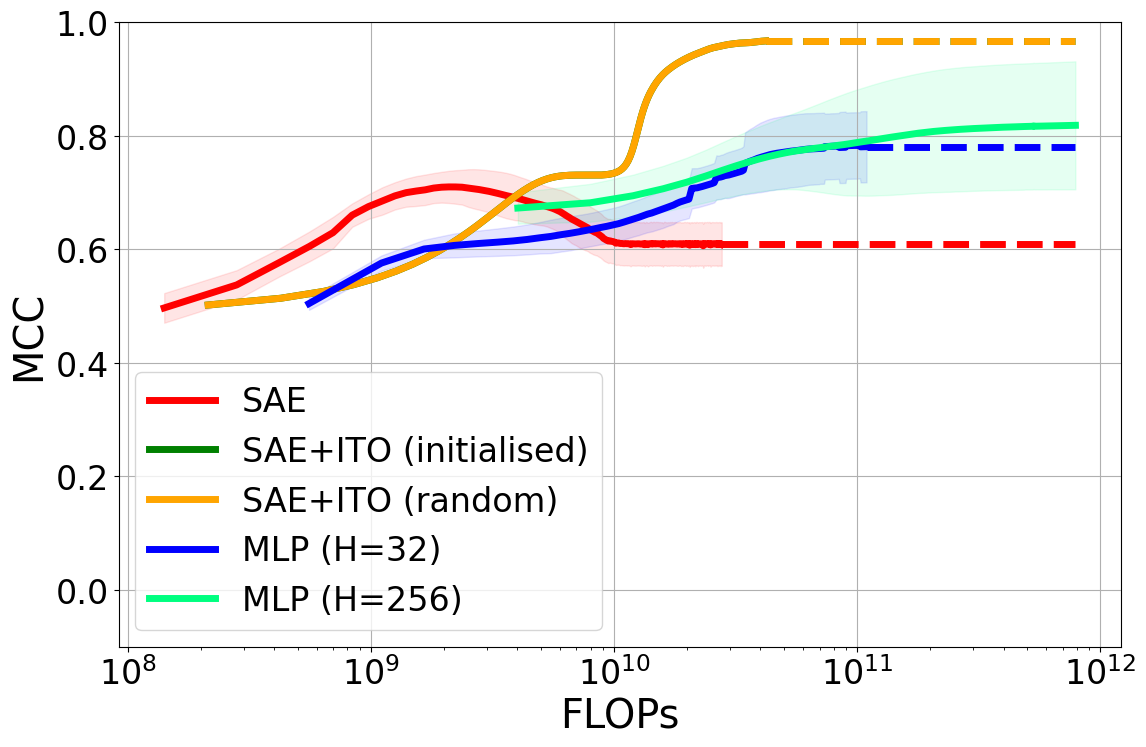

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['flops'][-1],
    data['SAE_ITO_init']['flops'][-1],
    data['SAE_ITO_random']['flops'][-1],
    max(data['MLPs'][h]['flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_mcc[-1], sae_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO_init
sae_ito_init_flops = np.array(data['SAE_ITO_init']['flops']) + np.array(data['SAE']['flops'])
sae_ito_init_mcc = np.array(data['SAE_ITO_init']['mcc_test'])
sae_ito_init_mcc_std = np.array(data['SAE_ITO_init']['mcc_test_std'])

plt.plot(sae_ito_init_flops, sae_ito_init_mcc, '-', color='green', label='SAE+ITO (initialised)', linewidth=linewidth)
plt.fill_between(sae_ito_init_flops, sae_ito_init_mcc - sae_ito_init_mcc_std, sae_ito_init_mcc + sae_ito_init_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO_init line
plt.plot([sae_ito_init_flops[-1], max_flops], [sae_ito_init_mcc[-1], sae_ito_init_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot SAE_ITO_random
sae_ito_random_flops = np.array(data['SAE_ITO_random']['flops']) + np.array(data['SAE']['flops'])
sae_ito_random_mcc = np.array(data['SAE_ITO_random']['mcc_test'])
sae_ito_random_mcc_std = np.array(data['SAE_ITO_random']['mcc_test_std'])

plt.plot(sae_ito_random_flops, sae_ito_random_mcc, '-', color='orange', label='SAE+ITO (random)', linewidth=linewidth)
plt.fill_between(sae_ito_random_flops, sae_ito_random_mcc - sae_ito_random_mcc_std, sae_ito_random_mcc + sae_ito_random_mcc_std, alpha=alpha, color='orange')
# Extend SAE_ITO_random line
plt.plot([sae_ito_random_flops[-1], max_flops], [sae_ito_random_mcc[-1], sae_ito_random_mcc[-1]], '--', color='orange', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_mcc[-1], mlp_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_D_flops_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

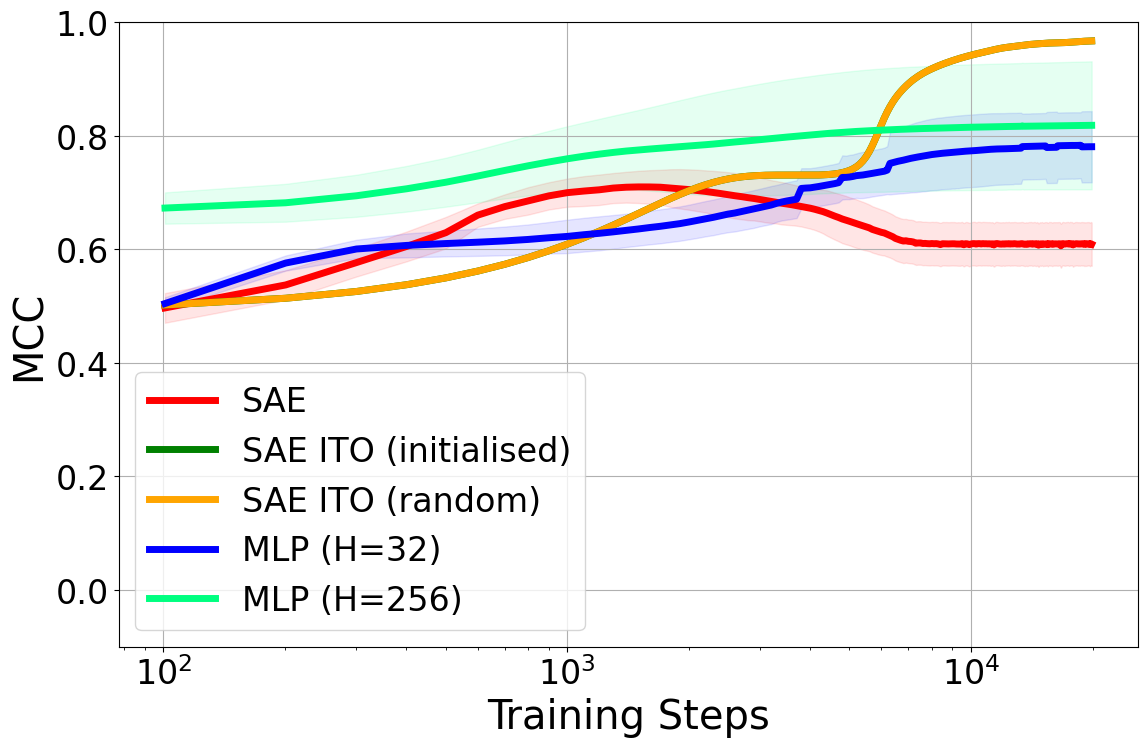

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito_init = data['SAE_ITO_init']
avg_sae_ito_random = data['SAE_ITO_random']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['mcc_test']) - np.array(avg_sae['mcc_test_std']),
                 np.array(avg_sae['mcc_test']) + np.array(avg_sae['mcc_test_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO_init
plt.plot(np.array(avg_sae_ito_init['step']) + 1, avg_sae_ito_init['mcc_test'], '-',
         color='green', label='SAE ITO (initialised)', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito_init['step']) + 1,
                 np.array(avg_sae_ito_init['mcc_test']) - np.array(avg_sae_ito_init['mcc_test_std']),
                 np.array(avg_sae_ito_init['mcc_test']) + np.array(avg_sae_ito_init['mcc_test_std']),
                 alpha=alpha, color='green')

# Plot SAE_ITO_random
plt.plot(np.array(avg_sae_ito_random['step']) + 1, avg_sae_ito_random['mcc_test'], '-',
         color='orange', label='SAE ITO (random)', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito_random['step']) + 1,
                 np.array(avg_sae_ito_random['mcc_test']) - np.array(avg_sae_ito_random['mcc_test_std']),
                 np.array(avg_sae_ito_random['mcc_test']) + np.array(avg_sae_ito_random['mcc_test_std']),
                 alpha=alpha, color='orange')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['mcc_test']) - np.array(avg_mlp['mcc_test_std']),
                     np.array(avg_mlp['mcc_test']) + np.array(avg_mlp['mcc_test_std']),
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_D_training_steps_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Unknown $Z^*$ and $D^*$

In [25]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc, greedy_mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SparseAutoEncoder(nn.Module):
    def __init__(self, M, N, D, learn_D=True, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        self.decoder = nn.Linear(N, M, bias=False)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class MLP(nn.Module):
    def __init__(self, M, N, h, D, learn_D=True, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU())
        self.decoder = nn.Linear(N, M)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T.clone(), requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        if learn_D:
            self.D = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D = nn.Parameter(data=D, requires_grad=False)
        self.log_S = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)

    def forward(self, X):
        if self.learn_D:
            self.D.data /= torch.linalg.norm(self.D.data, dim=0, keepdim=True)
        S = torch.exp(self.log_S)
        X_ = S @ self.D
        return S, X_

    def optimize_codes(self, X, num_iterations=1000, lr=1e-3):
        log_S_ = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)
        opt = torch.optim.Adam([log_S_], lr=lr)

        for j in range(num_iterations):
            S = torch.exp(log_S_)
            X_ = S @ self.D
            loss = reconstruction_loss_with_l1(X, X_, S)
            opt.zero_grad()
            loss.backward()
            opt.step()

        return torch.exp(log_S_.detach())

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.01):
    recon_loss = F.mse_loss(X_, X)
    l1_loss = l1_weight * torch.mean(torch.abs(S_))
    return recon_loss + l1_loss

def calculate_dict_mcc(D_true, D_learned):
    return greedy_mcc(D_true.T.cpu().numpy(), D_learned.T.cpu().numpy())

def calculate_optimize_codes_flops(M, N, num_data, num_iterations):
    # Initialization FLOPs
    init_flops = M * N + N

    # FLOPs per iteration
    flops_per_iteration = 4 * M * N + 2 * M + 11 * N

    # Total FLOPs
    total_flops = init_flops + (flops_per_iteration * num_iterations)

    # Multiply by num_data as this is done for each data point
    return total_flops * num_data

def train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            # Optimize codes for test set
            #with torch.no_grad():
            S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ model.D
            loss_test = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            
            mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            log['loss_test'].append(loss_test.item())
            log['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC
            dict_mcc = calculate_dict_mcc(D_true, model.D.data)
            log['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs
            train_flops = calculate_sparse_coding_training_flops(M, N, X_train.shape[0], i+1, learn_D=model.learn_D)
            #test_flops = calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False)  # We're not learning D during testing
            test_flops = calculate_optimize_codes_flops(M, N, X_test.shape[0], 10_000)
            log['train_flops'].append(train_flops)
            log['test_flops'].append(test_flops)

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}, Dict MCC = {dict_mcc:.4f}")

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
    return log, model.D.data

def train(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC
            if isinstance(model, SparseAutoEncoder) or isinstance(model, MLP):
                D_learned = model.decoder.weight.data.T
            elif isinstance(model, SparseCoding):
                D_learned = model.D_.data
            dict_mcc = calculate_dict_mcc(D_true, D_learned)
            log['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs
            if isinstance(model, SparseAutoEncoder):
                train_flops = calculate_sae_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_sae_inference_flops(M, N, num_data)
            elif isinstance(model, MLP):
                h = model.encoder[0].out_features
                train_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_mlp_inference_flops(M, h, N, num_data)
            elif isinstance(model, SparseCoding):
                train_flops = calculate_sparse_coding_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_sparse_coding_inference_flops(M, N, num_data, learn_D=model.learn_D)
            log['train_flops'].append(train_flops)
            log['test_flops'].append(test_flops)

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}, Dict MCC = {dict_mcc:.4f} (Train: {train_flops/1e9:.2f}B, Test: {test_flops/1e9:.2f}B)")

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
    return log, model.decoder.weight.data.T if hasattr(model, 'decoder') else model.D_.data

def train_sae_with_ito(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log_sae = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    log_ito = {'step': [], 'mcc_test': [], 'loss_test': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log_sae['step'].append(i)
            log_sae['loss_train'].append(loss.item())
            log_sae['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log_sae['loss_test'].append(loss_test)
            log_sae['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC for SAE
            D_learned = model.decoder.weight.data.T
            dict_mcc = calculate_dict_mcc(D_true, D_learned)
            log_sae['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs for SAE
            train_flops = calculate_sae_training_flops(M, N, X_train.shape[0], i+1, learn_D=model.learn_D)
            test_flops = calculate_sae_inference_flops(M, N, X_test.shape[0])
            log_sae['train_flops'].append(train_flops)
            log_sae['test_flops'].append(test_flops)

            # Run SAE_ITO
            ito_model = SparseCoding(X_test, D_learned, learn_D=False).to(device)
            S_test_opt = ito_model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ ito_model.D
            loss_test_ito = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            mcc_test_ito = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            
            log_ito['step'].append(i)
            log_ito['loss_test'].append(loss_test_ito.item())
            log_ito['mcc_test'].append(mcc_test_ito)
            log_ito['dict_mcc'].append(dict_mcc)  # Same as SAE
            #log_ito['test_flops'].append(calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False))
            log_ito['test_flops'].append(calculate_optimize_codes_flops(M, N, X_test.shape[0], 10_000))

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: SAE Loss Test = {loss_test:.4f}, SAE MCC Test = {mcc_test:.4f}, SAE Dict MCC = {dict_mcc:.4f}")
                print(f"         ITO Loss Test = {loss_test_ito:.4f}, ITO MCC Test = {mcc_test_ito:.4f}")

    print(f"Final SAE MCC: {log_sae['mcc_test'][-1]:.4f}, Final SAE Dict MCC: {log_sae['dict_mcc'][-1]:.4f}")
    print(f"Final ITO MCC: {log_ito['mcc_test'][-1]:.4f}")
    return log_sae, log_ito, D_learned

def run_experiment(model, X_train, S_train, X_test, S_test, D_true, num_step=30000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    if isinstance(model, SparseCoding):
        if model.learn_D:
            log, learned_D = train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            return log, None, learned_D
        else:
            # This is the standalone SAE_ITO case (not used in the main loop anymore)
            S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ model.D
            loss_test = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            dict_mcc = calculate_dict_mcc(D_true, model.D.data)
            test_flops = calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False)
            log = {
                'step': [num_step],
                'mcc_test': [mcc_test],
                'loss_test': [loss_test.item()],
                'train_flops': [0],  # No training for SAE_ITO
                'test_flops': [test_flops],
                'dict_mcc': [dict_mcc]
            }
            learned_D = model.D.data
            print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
            return log, None, learned_D
    elif isinstance(model, SparseAutoEncoder):
        return train_sae_with_ito(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
    else:  # MLP
        log, learned_D = train(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
        return log, None, learned_D

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'dict_mcc': np.mean([log['dict_mcc'] for log in logs], axis=0),
        'dict_mcc_std': np.std([log['dict_mcc'] for log in logs], axis=0),
        'train_flops': logs[0]['train_flops'],
        'test_flops': logs[0]['test_flops']
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 100_000
log_step = 2500
seed = 20240926

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)
D_true = D.to(device)

# Run experiments
logs_sae = []
logs_sae_ito = []
logs_mlps = {h: [] for h in hidden_layers}
logs_sparse_coding = []

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i

    # Sparse Coding
    SC = SparseCoding(X_test, D.to(device), learn_D=True, seed=run_seed).to(device)
    print(f"Running experiment {i+1}/{num_runs} with Sparse Coding")
    sc_log, _, _ = run_experiment(SC, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
    logs_sparse_coding.append(sc_log)

    # SAE and SAE_ITO
    SAE = SparseAutoEncoder(M, N, D.to(device), learn_D=True, seed=run_seed).to(device)
    print(f"Running experiment {i+1}/{num_runs} with SAE and SAE_ITO")
    sae_log, sae_ito_log, _ = run_experiment(SAE, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
    logs_sae.append(sae_log)
    logs_sae_ito.append(sae_ito_log)
    
    for h in hidden_layers:
        print(f"Running experiment {i+1}/{num_runs} with MLP (H={h})")
        MLP_model = MLP(M, N, h, D.to(device), learn_D=True, seed=run_seed).to(device)
        mlp_log, _, _ = run_experiment(MLP_model, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
        logs_mlps[h].append(mlp_log)

def average_logs(logs, ito=False, sae_avg_logs=None):
    if ito:
        assert sae_avg_logs is not None, "SAE average logs must be provided if ito=True"
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'dict_mcc': np.mean([log['dict_mcc'] for log in logs], axis=0),
        'dict_mcc_std': np.std([log['dict_mcc'] for log in logs], axis=0),
        'train_flops': logs[0]['train_flops'] if not ito else sae_avg_logs['train_flops'],
        'test_flops': logs[0]['test_flops']
    }
    return avg_log

# Average logs
avg_sae = average_logs(logs_sae)
avg_sae_ito = average_logs(logs_sae_ito, ito=True, sae_avg_logs=avg_sae)
avg_sparse_coding = average_logs(logs_sparse_coding)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "SAE_ITO": avg_sae_ito,
    "SparseCoding": avg_sparse_coding,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/unknown_Z_D_flops_reconstruction.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/unknown_Z_D_flops_reconstruction.json'.")

Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Running experiment 1/5 with Sparse Coding
Step 0: Loss Test = 0.1788, MCC Test = 0.4149, Dict MCC = 0.6800
Step 5000: Loss Test = 0.2508, MCC Test = 0.3588, Dict MCC = 0.4801
Step 10000: Loss Test = 0.0170, MCC Test = 0.5516, Dict MCC = 0.7317
Step 15000: Loss Test = 0.0131, MCC Test = 0.5974, Dict MCC = 0.7646
Step 20000: Loss Test = 0.0113, MCC Test = 0.6550, Dict MCC = 0.8215
Step 25000: Loss Test = 0.0096, MCC Test = 0.6799, Dict MCC = 0.8318
Step 30000: Loss Test = 0.0104, MCC Test = 0.6640, Dict MCC = 0.8080
Step 35000: Loss Test = 0.0102, MCC Test = 0.6701, Dict MCC = 0.8115
Step 40000: Loss Test = 0.0098, MCC Test = 0.6659, Dict MCC = 0.8110
Step 45000: Loss Test = 0.0093, MCC Test = 0.6729, Dict MCC = 0.8193
Step 50000: Loss Test = 0.0097, MCC Test = 0.6719, Dict MCC = 0.8118
Step 55000: Loss Test = 0.0097, MCC Test = 0.6689, Dict MCC = 0.8069
Step 60000: Loss Test = 0.0097, MCC Test = 0.6670, Dict MCC = 0.8011
Step 65000: Loss Test = 0.0094, MCC Test = 0.6715, Dict MCC = 0.79

Running experiments:  20%|██        | 1/5 [07:38<30:33, 458.39s/it]

Final MCC: 0.7028, Final Dict MCC: 0.8976
Running experiment 2/5 with Sparse Coding
Step 0: Loss Test = 0.1055, MCC Test = 0.4090, Dict MCC = 0.6563
Step 5000: Loss Test = 0.2327, MCC Test = 0.3586, Dict MCC = 0.4885
Step 10000: Loss Test = 0.0133, MCC Test = 0.6393, Dict MCC = 0.8029
Step 15000: Loss Test = 0.0099, MCC Test = 0.6611, Dict MCC = 0.8201
Step 20000: Loss Test = 0.0093, MCC Test = 0.6804, Dict MCC = 0.8289
Step 25000: Loss Test = 0.0095, MCC Test = 0.6885, Dict MCC = 0.8458
Step 30000: Loss Test = 0.0090, MCC Test = 0.6834, Dict MCC = 0.8358
Step 35000: Loss Test = 0.0083, MCC Test = 0.6786, Dict MCC = 0.8318
Step 40000: Loss Test = 0.0080, MCC Test = 0.6755, Dict MCC = 0.8305
Step 45000: Loss Test = 0.0079, MCC Test = 0.6773, Dict MCC = 0.8278
Step 50000: Loss Test = 0.0082, MCC Test = 0.6838, Dict MCC = 0.8257
Step 55000: Loss Test = 0.0085, MCC Test = 0.6851, Dict MCC = 0.8253
Step 60000: Loss Test = 0.0084, MCC Test = 0.6822, Dict MCC = 0.8233
Step 65000: Loss Test = 

Running experiments:  40%|████      | 2/5 [14:17<21:10, 423.62s/it]

Final MCC: 0.4284, Final Dict MCC: 0.7783
Running experiment 3/5 with Sparse Coding
Step 0: Loss Test = 0.0679, MCC Test = 0.5016, Dict MCC = 0.7046
Step 5000: Loss Test = 0.2502, MCC Test = 0.3480, Dict MCC = 0.4751
Step 10000: Loss Test = 0.0177, MCC Test = 0.5117, Dict MCC = 0.7845
Step 15000: Loss Test = 0.0132, MCC Test = 0.5741, Dict MCC = 0.7882
Step 20000: Loss Test = 0.0107, MCC Test = 0.6120, Dict MCC = 0.8340
Step 25000: Loss Test = 0.0119, MCC Test = 0.6105, Dict MCC = 0.8104
Step 30000: Loss Test = 0.0116, MCC Test = 0.5971, Dict MCC = 0.8008
Step 35000: Loss Test = 0.0114, MCC Test = 0.6010, Dict MCC = 0.7991
Step 40000: Loss Test = 0.0114, MCC Test = 0.6150, Dict MCC = 0.7987
Step 45000: Loss Test = 0.0112, MCC Test = 0.6144, Dict MCC = 0.7968
Step 50000: Loss Test = 0.0112, MCC Test = 0.6242, Dict MCC = 0.7982
Step 55000: Loss Test = 0.0110, MCC Test = 0.6247, Dict MCC = 0.7976
Step 60000: Loss Test = 0.0108, MCC Test = 0.6279, Dict MCC = 0.7989
Step 65000: Loss Test = 

Running experiments:  60%|██████    | 3/5 [21:09<13:56, 418.07s/it]

Final MCC: 0.6729, Final Dict MCC: 0.8601
Running experiment 4/5 with Sparse Coding
Step 0: Loss Test = 0.1061, MCC Test = 0.4610, Dict MCC = 0.6650
Step 5000: Loss Test = 0.2497, MCC Test = 0.3459, Dict MCC = 0.4764
Step 10000: Loss Test = 0.0186, MCC Test = 0.5334, Dict MCC = 0.7576
Step 15000: Loss Test = 0.0134, MCC Test = 0.5932, Dict MCC = 0.7777
Step 20000: Loss Test = 0.0104, MCC Test = 0.6128, Dict MCC = 0.8058
Step 25000: Loss Test = 0.0100, MCC Test = 0.6252, Dict MCC = 0.7984
Step 30000: Loss Test = 0.0090, MCC Test = 0.6479, Dict MCC = 0.8099
Step 35000: Loss Test = 0.0091, MCC Test = 0.6498, Dict MCC = 0.8218
Step 40000: Loss Test = 0.0091, MCC Test = 0.6457, Dict MCC = 0.8347
Step 45000: Loss Test = 0.0089, MCC Test = 0.6478, Dict MCC = 0.8359
Step 50000: Loss Test = 0.0086, MCC Test = 0.6446, Dict MCC = 0.8245
Step 55000: Loss Test = 0.0083, MCC Test = 0.6490, Dict MCC = 0.8242
Step 60000: Loss Test = 0.0083, MCC Test = 0.6488, Dict MCC = 0.8252
Step 65000: Loss Test = 

Running experiments:  80%|████████  | 4/5 [27:25<06:41, 401.55s/it]

Final MCC: 0.5257, Final Dict MCC: 0.8088
Running experiment 5/5 with Sparse Coding
Step 0: Loss Test = 0.1027, MCC Test = 0.4644, Dict MCC = 0.6173
Step 5000: Loss Test = 0.2504, MCC Test = 0.3935, Dict MCC = 0.4887
Step 10000: Loss Test = 0.0169, MCC Test = 0.5162, Dict MCC = 0.7644
Step 15000: Loss Test = 0.0133, MCC Test = 0.6406, Dict MCC = 0.8259
Step 20000: Loss Test = 0.0083, MCC Test = 0.7115, Dict MCC = 0.8507
Step 25000: Loss Test = 0.0083, MCC Test = 0.7362, Dict MCC = 0.8672
Step 30000: Loss Test = 0.0084, MCC Test = 0.7223, Dict MCC = 0.8524
Step 35000: Loss Test = 0.0082, MCC Test = 0.7124, Dict MCC = 0.8531
Step 40000: Loss Test = 0.0083, MCC Test = 0.7160, Dict MCC = 0.8526
Step 45000: Loss Test = 0.0081, MCC Test = 0.7092, Dict MCC = 0.8485
Step 50000: Loss Test = 0.0080, MCC Test = 0.7035, Dict MCC = 0.8565
Step 55000: Loss Test = 0.0079, MCC Test = 0.7048, Dict MCC = 0.8594
Step 60000: Loss Test = 0.0079, MCC Test = 0.7014, Dict MCC = 0.8557
Step 65000: Loss Test = 

Running experiments: 100%|██████████| 5/5 [33:58<00:00, 407.70s/it]

Final MCC: 0.6147, Final Dict MCC: 0.8212
Experiment completed. Results saved to 'results/unknown_Z_D_flops_reconstruction.json'.


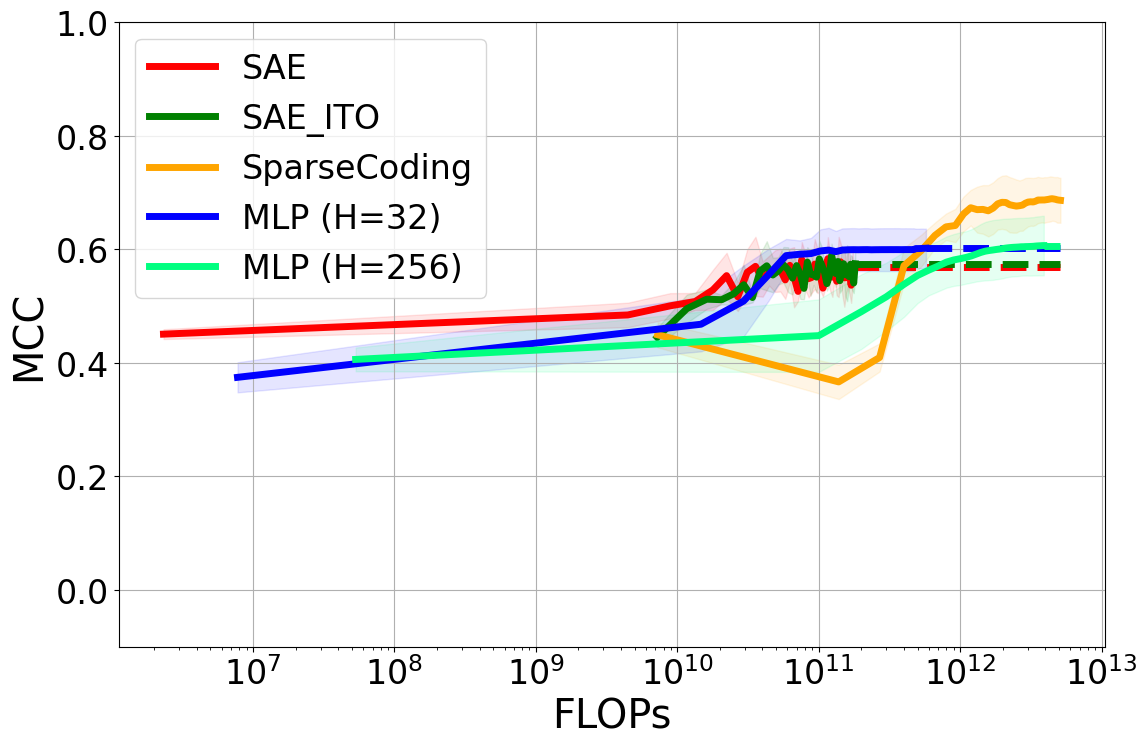

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['train_flops'][-1] + data['SAE']['test_flops'][-1],
    data['SAE_ITO']['train_flops'][-1] + data['SAE_ITO']['test_flops'][-1],
    data['SparseCoding']['train_flops'][-1] + data['SparseCoding']['test_flops'][-1],
    max(data['MLPs'][h]['train_flops'][-1] + data['MLPs'][h]['test_flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['train_flops']) + np.array(data['SAE']['test_flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_mcc[-1], sae_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['train_flops']) + np.array(data['SAE_ITO']['test_flops'])
sae_ito_mcc = np.array(data['SAE_ITO']['mcc_test'])
sae_ito_mcc_std = np.array(data['SAE_ITO']['mcc_test_std'])

plt.plot(sae_ito_flops, sae_ito_mcc, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_mcc - sae_ito_mcc_std, sae_ito_mcc + sae_ito_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_mcc[-1], sae_ito_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot SparseCoding
sc_flops = np.array(data['SparseCoding']['train_flops']) + np.array(data['SparseCoding']['test_flops'])
sc_mcc = np.array(data['SparseCoding']['mcc_test'])
sc_mcc_std = np.array(data['SparseCoding']['mcc_test_std'])

plt.plot(sc_flops, sc_mcc, '-', color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(sc_flops, sc_mcc - sc_mcc_std, sc_mcc + sc_mcc_std, alpha=alpha, color='orange')
# Extend SparseCoding line
plt.plot([sc_flops[-1], max_flops], [sc_mcc[-1], sc_mcc[-1]], '--', color='orange', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['train_flops']) + np.array(mlp_data['test_flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_mcc[-1], mlp_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
#plt.savefig('results/figures/unknown_Z_D_flops_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

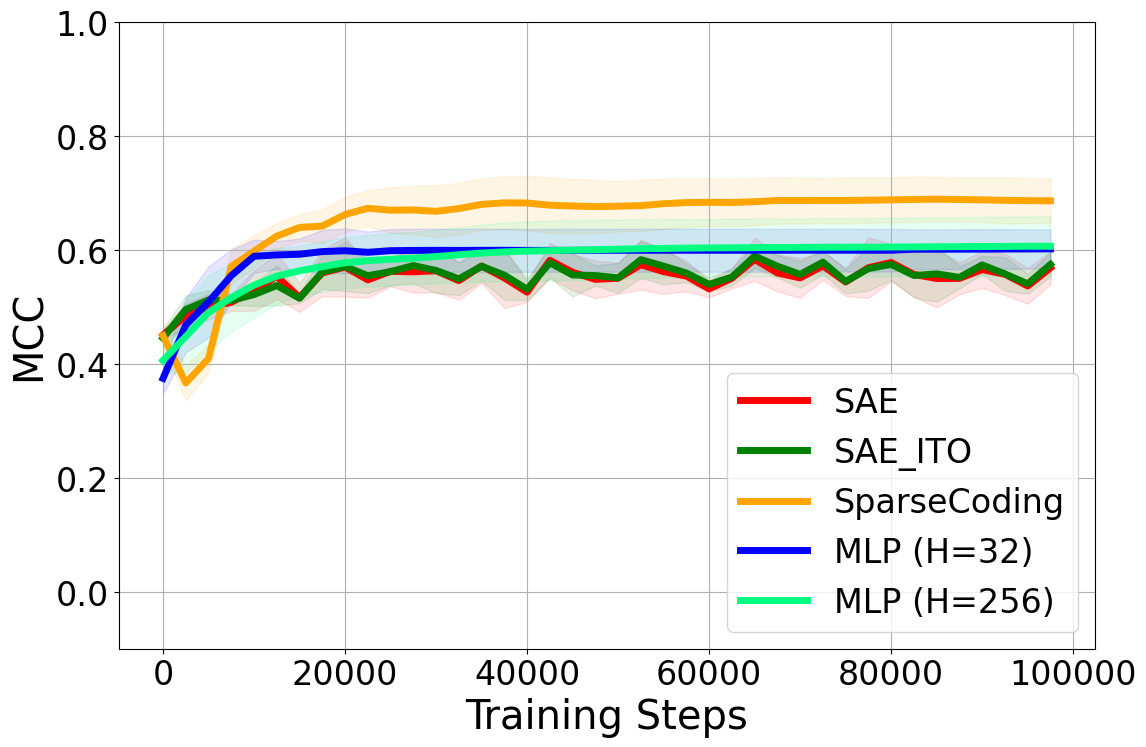

In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_sparse_coding = data['SparseCoding']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['mcc_test']) - np.array(avg_sae['mcc_test_std']),
                 np.array(avg_sae['mcc_test']) + np.array(avg_sae['mcc_test_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['mcc_test'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['mcc_test']) - np.array(avg_sae_ito['mcc_test_std']),
                 np.array(avg_sae_ito['mcc_test']) + np.array(avg_sae_ito['mcc_test_std']),
                 alpha=alpha, color='green')

# Plot SparseCoding
plt.plot(np.array(avg_sparse_coding['step']) + 1, avg_sparse_coding['mcc_test'], '-',
         color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(np.array(avg_sparse_coding['step']) + 1,
                 np.array(avg_sparse_coding['mcc_test']) - np.array(avg_sparse_coding['mcc_test_std']),
                 np.array(avg_sparse_coding['mcc_test']) + np.array(avg_sparse_coding['mcc_test_std']),
                 alpha=alpha, color='orange')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['mcc_test']) - np.array(avg_mlp['mcc_test_std']),
                     np.array(avg_mlp['mcc_test']) + np.array(avg_mlp['mcc_test_std']),
                     alpha=alpha, color=color)

#plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
#plt.savefig('results/figures/unknown_Z_D_training_steps_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

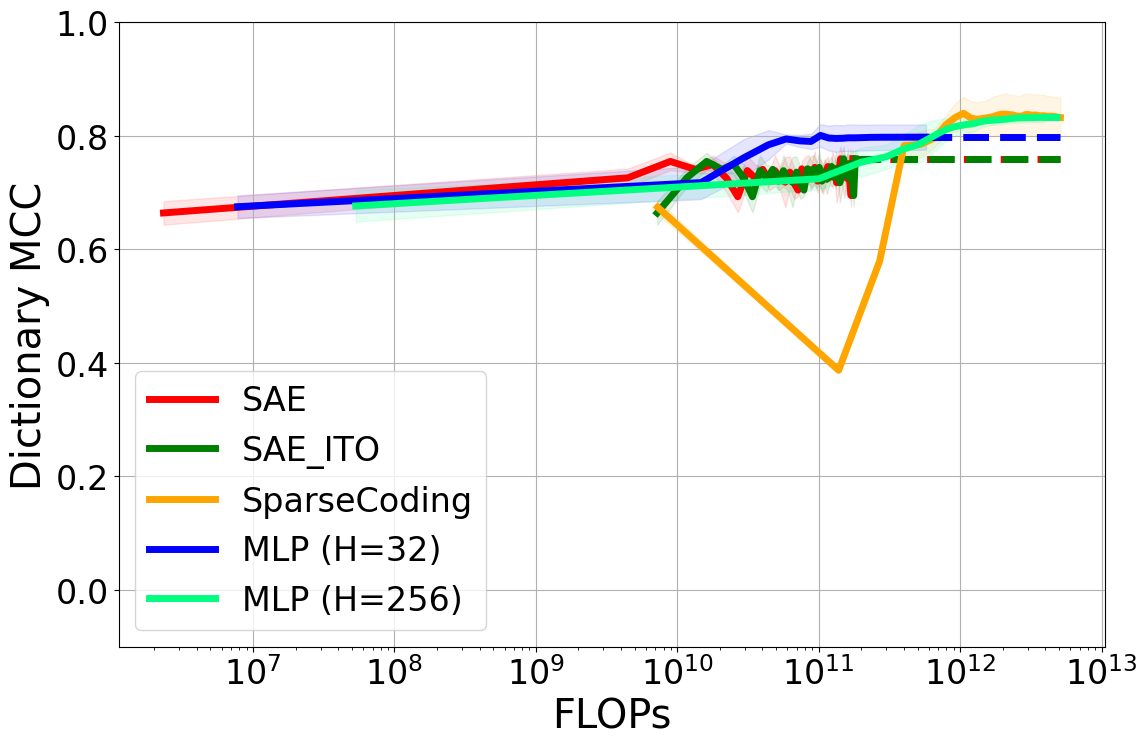

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['train_flops'][-1] + data['SAE']['test_flops'][-1],
    data['SAE_ITO']['train_flops'][-1] + data['SAE_ITO']['test_flops'][-1],
    data['SparseCoding']['train_flops'][-1] + data['SparseCoding']['test_flops'][-1],
    max(data['MLPs'][h]['train_flops'][-1] + data['MLPs'][h]['test_flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['train_flops']) + np.array(data['SAE']['test_flops'])
sae_dict_mcc = np.array(data['SAE']['dict_mcc'])
sae_dict_mcc_std = np.array(data['SAE']['dict_mcc_std'])

plt.plot(sae_flops, sae_dict_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_dict_mcc - sae_dict_mcc_std, sae_dict_mcc + sae_dict_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_dict_mcc[-1], sae_dict_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['train_flops']) + np.array(data['SAE_ITO']['test_flops'])
sae_ito_dict_mcc = np.array(data['SAE_ITO']['dict_mcc'])
sae_ito_dict_mcc_std = np.array(data['SAE_ITO']['dict_mcc_std'])

plt.plot(sae_ito_flops, sae_ito_dict_mcc, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_dict_mcc - sae_ito_dict_mcc_std, sae_ito_dict_mcc + sae_ito_dict_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_dict_mcc[-1], sae_ito_dict_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot SparseCoding
sc_flops = np.array(data['SparseCoding']['train_flops']) + np.array(data['SparseCoding']['test_flops'])
sc_dict_mcc = np.array(data['SparseCoding']['dict_mcc'])
sc_dict_mcc_std = np.array(data['SparseCoding']['dict_mcc_std'])

plt.plot(sc_flops, sc_dict_mcc, '-', color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(sc_flops, sc_dict_mcc - sc_dict_mcc_std, sc_dict_mcc + sc_dict_mcc_std, alpha=alpha, color='orange')
# Extend SparseCoding line
plt.plot([sc_flops[-1], max_flops], [sc_dict_mcc[-1], sc_dict_mcc[-1]], '--', color='orange', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['train_flops']) + np.array(mlp_data['test_flops'])
    mlp_dict_mcc = np.array(mlp_data['dict_mcc'])
    mlp_dict_mcc_std = np.array(mlp_data['dict_mcc_std'])
    
    plt.plot(mlp_flops, mlp_dict_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_dict_mcc - mlp_dict_mcc_std, mlp_dict_mcc + mlp_dict_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_dict_mcc[-1], mlp_dict_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('Dictionary MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
#plt.savefig('results/figures/unknown_Z_D_flops_dict_mcc.pdf', dpi=300, bbox_inches='tight')
plt.show()

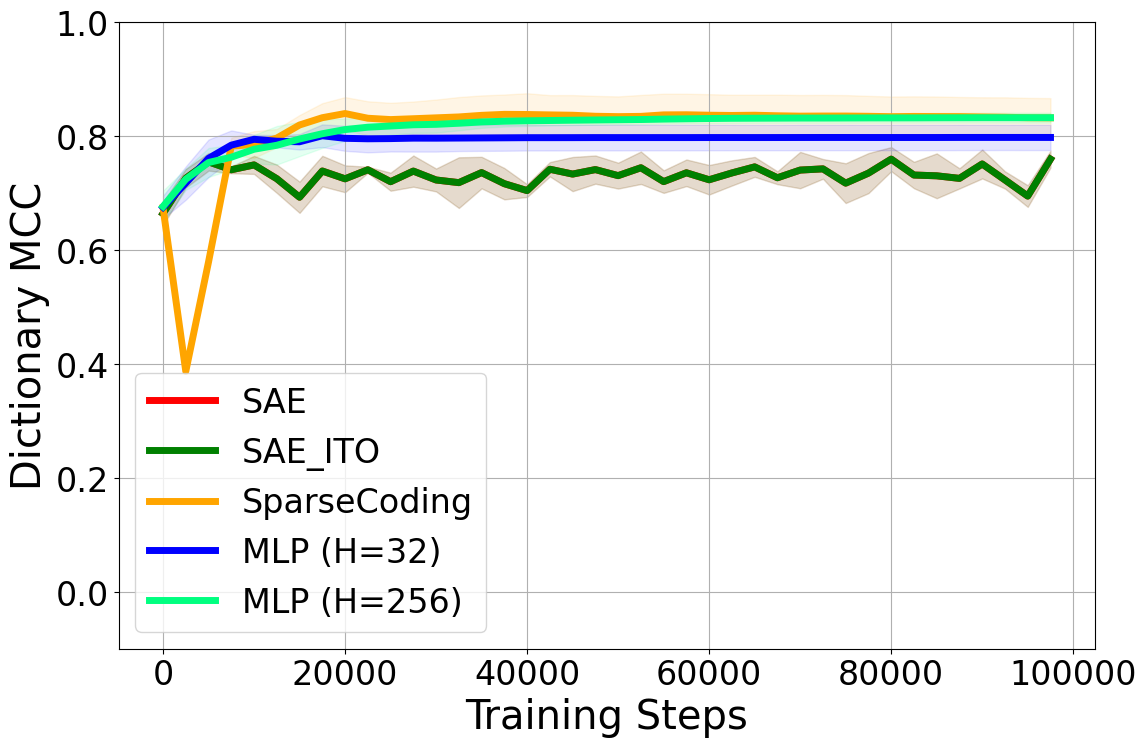

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_sparse_coding = data['SparseCoding']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['dict_mcc'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['dict_mcc']) - np.array(avg_sae['dict_mcc_std']),
                 np.array(avg_sae['dict_mcc']) + np.array(avg_sae['dict_mcc_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['dict_mcc'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['dict_mcc']) - np.array(avg_sae_ito['dict_mcc_std']),
                 np.array(avg_sae_ito['dict_mcc']) + np.array(avg_sae_ito['dict_mcc_std']),
                 alpha=alpha, color='green')

# Plot SparseCoding
plt.plot(np.array(avg_sparse_coding['step']) + 1, avg_sparse_coding['dict_mcc'], '-',
         color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(np.array(avg_sparse_coding['step']) + 1,
                 np.array(avg_sparse_coding['dict_mcc']) - np.array(avg_sparse_coding['dict_mcc_std']),
                 np.array(avg_sparse_coding['dict_mcc']) + np.array(avg_sparse_coding['dict_mcc_std']),
                 alpha=alpha, color='orange')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['dict_mcc'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['dict_mcc']) - np.array(avg_mlp['dict_mcc_std']),
                     np.array(avg_mlp['dict_mcc']) + np.array(avg_mlp['dict_mcc_std']),
                     alpha=alpha, color=color)

#plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('Dictionary MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
#plt.savefig('results/figures/unknown_Z_D_training_steps_dict_mcc.pdf', dpi=300, bbox_inches='tight')
plt.show()

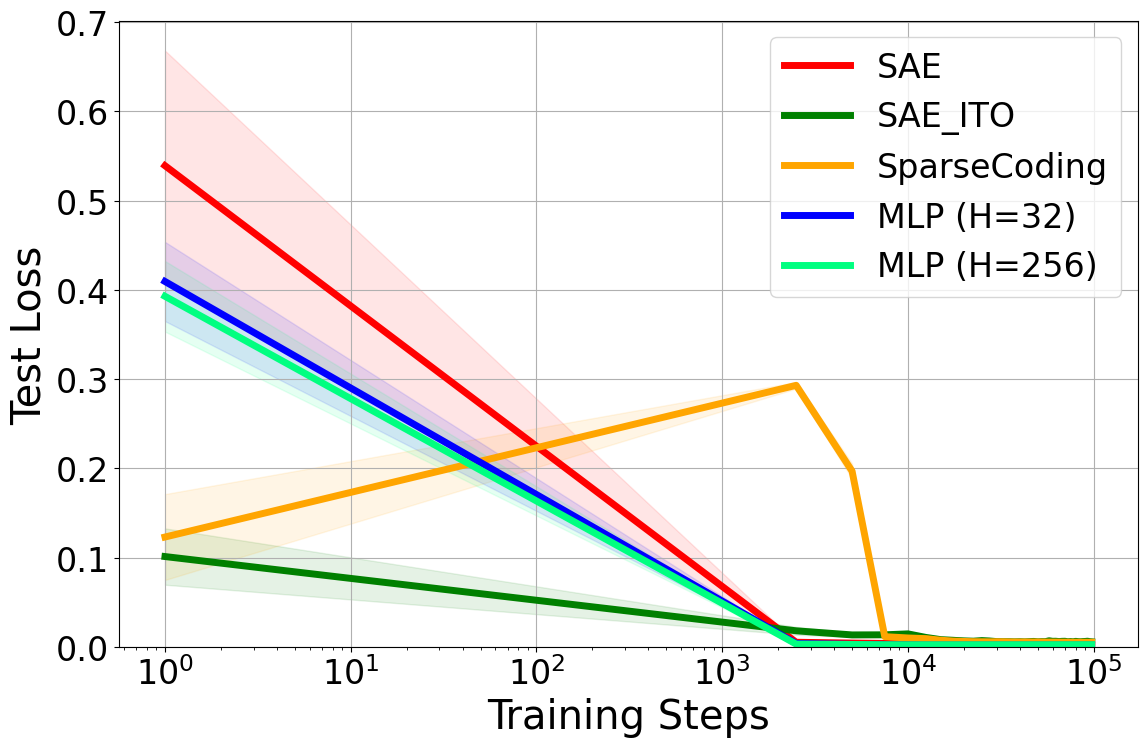

In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_sparse_coding = data['SparseCoding']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['loss_test'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['loss_test']) - np.array(avg_sae['loss_test_std']),
                 np.array(avg_sae['loss_test']) + np.array(avg_sae['loss_test_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['loss_test'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['loss_test']) - np.array(avg_sae_ito['loss_test_std']),
                 np.array(avg_sae_ito['loss_test']) + np.array(avg_sae_ito['loss_test_std']),
                 alpha=alpha, color='green')

# Plot SparseCoding
plt.plot(np.array(avg_sparse_coding['step']) + 1, avg_sparse_coding['loss_test'], '-',
         color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(np.array(avg_sparse_coding['step']) + 1,
                 np.array(avg_sparse_coding['loss_test']) - np.array(avg_sparse_coding['loss_test_std']),
                 np.array(avg_sparse_coding['loss_test']) + np.array(avg_sparse_coding['loss_test_std']),
                 alpha=alpha, color='orange')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['loss_test'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['loss_test']) - np.array(avg_mlp['loss_test_std']),
                     np.array(avg_mlp['loss_test']) + np.array(avg_mlp['loss_test_std']),
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('Test Loss', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(bottom=0)  # Adjust this if needed based on your loss values

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
#plt.savefig('results/figures/unknown_Z_D_training_steps_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

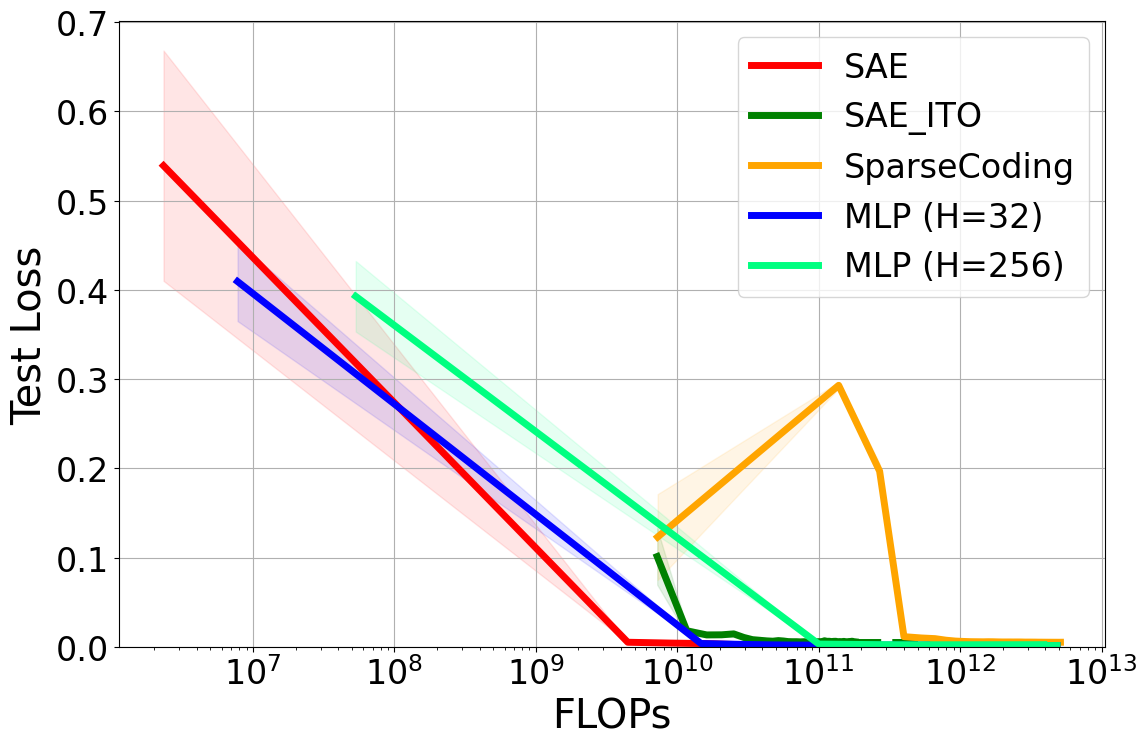

In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['train_flops'][-1] + data['SAE']['test_flops'][-1],
    data['SAE_ITO']['train_flops'][-1] + data['SAE_ITO']['test_flops'][-1],
    data['SparseCoding']['train_flops'][-1] + data['SparseCoding']['test_flops'][-1],
    max(data['MLPs'][h]['train_flops'][-1] + data['MLPs'][h]['test_flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['train_flops']) + np.array(data['SAE']['test_flops'])
sae_loss = np.array(data['SAE']['loss_test'])
sae_loss_std = np.array(data['SAE']['loss_test_std'])

plt.plot(sae_flops, sae_loss, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_loss - sae_loss_std, sae_loss + sae_loss_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_loss[-1], sae_loss[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['train_flops']) + np.array(data['SAE_ITO']['test_flops'])
sae_ito_loss = np.array(data['SAE_ITO']['loss_test'])
sae_ito_loss_std = np.array(data['SAE_ITO']['loss_test_std'])

plt.plot(sae_ito_flops, sae_ito_loss, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_loss - sae_ito_loss_std, sae_ito_loss + sae_ito_loss_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_loss[-1], sae_ito_loss[-1]], '--', color='green', linewidth=linewidth)

# Plot SparseCoding
sc_flops = np.array(data['SparseCoding']['train_flops']) + np.array(data['SparseCoding']['test_flops'])
sc_loss = np.array(data['SparseCoding']['loss_test'])
sc_loss_std = np.array(data['SparseCoding']['loss_test_std'])

plt.plot(sc_flops, sc_loss, '-', color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(sc_flops, sc_loss - sc_loss_std, sc_loss + sc_loss_std, alpha=alpha, color='orange')
# Extend SparseCoding line
plt.plot([sc_flops[-1], max_flops], [sc_loss[-1], sc_loss[-1]], '--', color='orange', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['train_flops']) + np.array(mlp_data['test_flops'])
    mlp_loss = np.array(mlp_data['loss_test'])
    mlp_loss_std = np.array(mlp_data['loss_test_std'])
    
    plt.plot(mlp_flops, mlp_loss, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_loss - mlp_loss_std, mlp_loss + mlp_loss_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_loss[-1], mlp_loss[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('Test Loss', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(bottom=0)  # Adjust this if needed based on your loss values

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
#plt.savefig('results/figures/unknown_Z_D_flops_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Pareto curves

[[0.         0.         1.         1.        ]
 [0.         0.50196078 0.74901961 1.        ]
 [0.         1.         0.5        1.        ]]


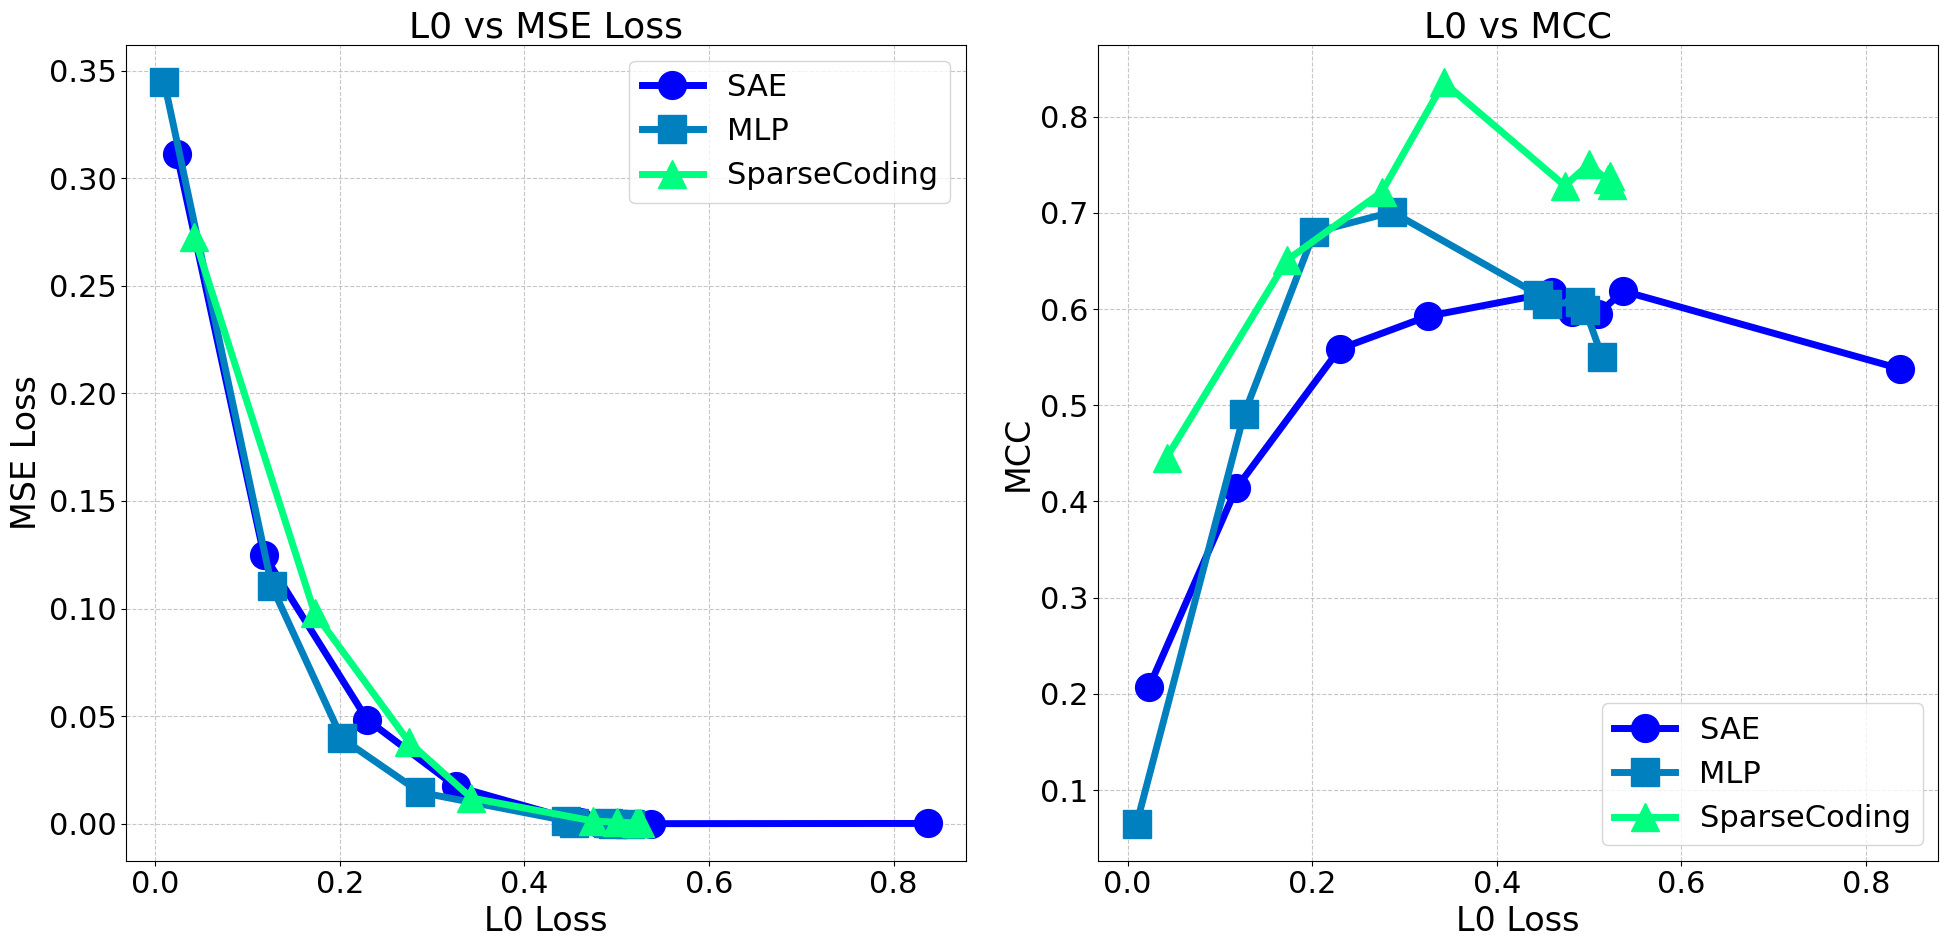

Plots saved to 'results/figures/l1_penalty_plots.pdf'.


In [34]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load results from JSON file
with open('results/l1_penalty_experiment.json', 'r') as f:
    results = json.load(f)

# Plot setup
plt.figure(figsize=(20, 10))

methods = list(results.keys())
colors = plt.cm.winter(np.linspace(0, 1.0, len(methods)))
print(colors)
markers = ['o', 's', '^']
base_fontsize = 24
linewidth = 5
markersize = 20

# Subplot for L0 vs MSE
plt.subplot(1, 2, 1)
for i, method in enumerate(methods):
    l0_values = [results[method][str(w)][3] for w in sorted(map(float, results[method].keys()))]  # Using l0_loss_1e4
    mse_values = [results[method][str(w)][0] for w in sorted(map(float, results[method].keys()))]
    plt.plot(l0_values, mse_values, color=colors[i], marker=markers[i], 
             linewidth=linewidth, markersize=markersize, label=method)

plt.xlabel('L0 Loss', fontsize=base_fontsize)
plt.ylabel('MSE Loss', fontsize=base_fontsize)
plt.title('L0 vs MSE Loss', fontsize=base_fontsize + 2)
plt.legend(fontsize=base_fontsize - 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=base_fontsize - 2)

# Subplot for L0 vs MCC
plt.subplot(1, 2, 2)
for i, method in enumerate(methods):
    l0_values = [results[method][str(w)][3] for w in sorted(map(float, results[method].keys()))]  # Using l0_loss_1e4
    mcc_values = [results[method][str(w)][6] for w in sorted(map(float, results[method].keys()))]  # MCC is at index 6
    plt.plot(l0_values, mcc_values, color=colors[i], marker=markers[i], 
             linewidth=linewidth, markersize=markersize, label=method)

plt.xlabel('L0 Loss', fontsize=base_fontsize)
plt.ylabel('MCC', fontsize=base_fontsize)
plt.title('L0 vs MCC', fontsize=base_fontsize + 2)
plt.legend(fontsize=base_fontsize - 2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=base_fontsize - 2)

plt.tight_layout()
plt.savefig('results/figures/l1_penalty_plots.pdf', dpi=300, bbox_inches='tight')
# plt.close()
plt.show()

print("Plots saved to 'results/figures/l1_penalty_plots.pdf'.")

In [37]:
[8 * 2**i for i in range(int(np.log2(64)) + 1)]

[8, 16, 32, 64, 128, 256, 512]

## MLPs

N16_M8_K3
N32_M16_K6
N64_M16_K6


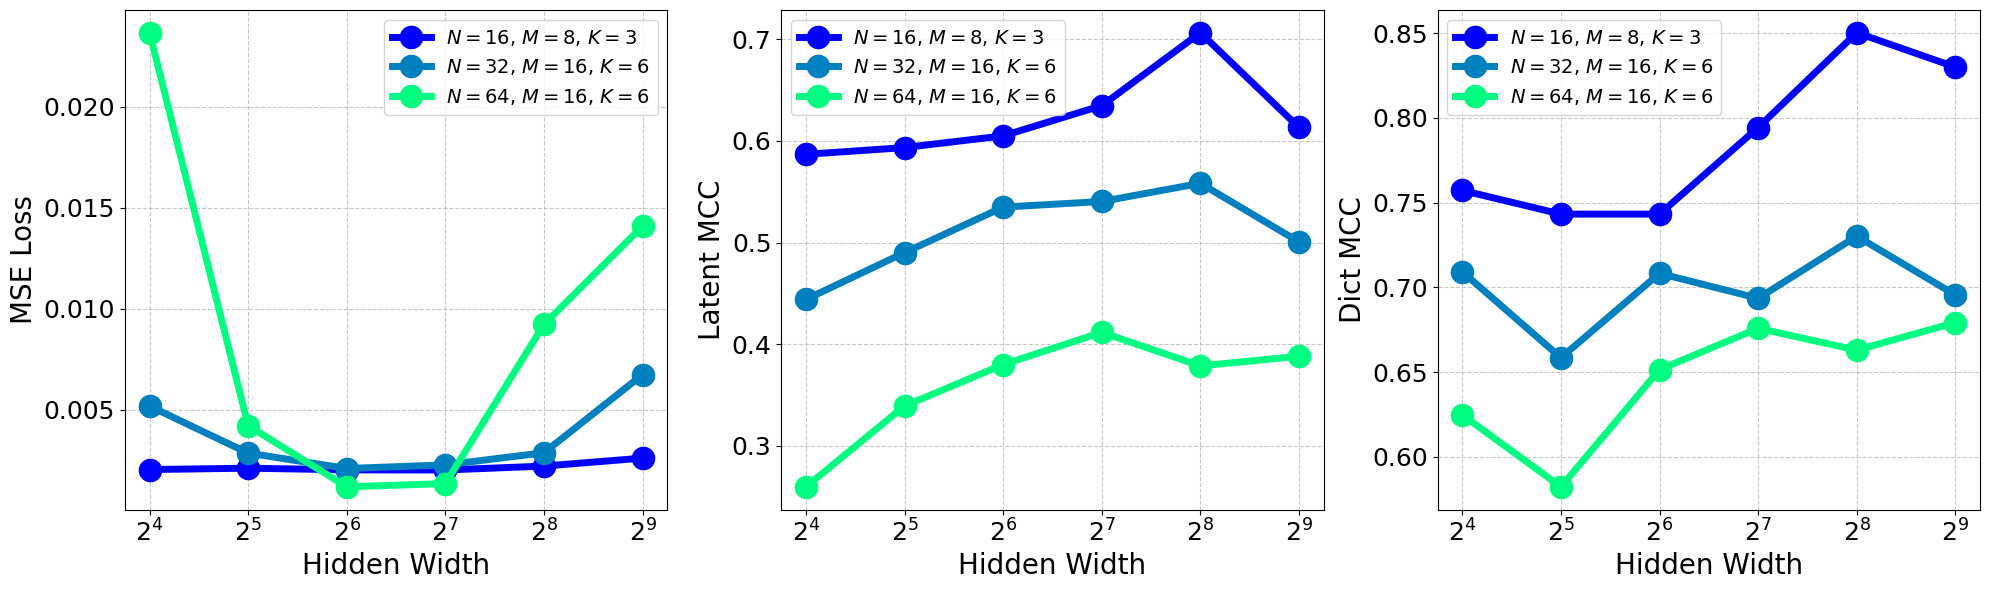

Plotting completed. Figure saved as 'mlp_performance_metrics.pdf'.


In [40]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def load_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def plot_results(results, base_fontsize=20, line_width=5, marker_size=16):
    configs = list(results.keys())
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.3)

    # Create a custom colormap based on the 'winter' colormap
    winter = plt.get_cmap('winter')
    colors = [winter(i) for i in np.linspace(0, 1, len(configs))]
    custom_cmap = LinearSegmentedColormap.from_list("custom_winter", colors, N=len(configs))

    for i, config in enumerate(configs):
        print(config)
        color = custom_cmap(i / (len(configs) - 1))
        hidden_widths = sorted([int(h) for h in results[config].keys()])
        
        loss_values = []
        mcc_values = []
        dict_mcc_values = []

        for h in hidden_widths:
            loss = np.mean([run['loss_test'] for run in results[config][str(h)]])
            mcc = np.mean([run['mcc_test'] for run in results[config][str(h)]])
            dict_mcc = np.mean([run['dict_mcc'] for run in results[config][str(h)]])

            loss_values.append(loss)
            mcc_values.append(mcc)
            dict_mcc_values.append(dict_mcc)

        # Create label
        N = config.split('N')[-1].split('_')[0]
        M = config.split('M')[-1].split('_')[0]
        K = config.split('K')[-1].split('_')[0]
        label = f"$N={N}$, $M={M}$, $K={K}$"
        
        # Plot test loss
        axs[0].plot(hidden_widths, loss_values, '-o', color=color, linewidth=line_width, markersize=marker_size, label=label)
        axs[0].set_xlabel('Hidden Width', fontsize=base_fontsize)
        axs[0].set_ylabel('MSE Loss', fontsize=base_fontsize)

        # Plot MCC
        axs[1].plot(hidden_widths, mcc_values, '-o', color=color, linewidth=line_width, markersize=marker_size, label=label)
        axs[1].set_xlabel('Hidden Width', fontsize=base_fontsize)
        axs[1].set_ylabel('Latent MCC', fontsize=base_fontsize)

        # Plot Dict MCC
        axs[2].plot(hidden_widths, dict_mcc_values, '-o', color=color, linewidth=line_width, markersize=marker_size, label=label)
        axs[2].set_xlabel('Hidden Width', fontsize=base_fontsize)
        axs[2].set_ylabel('Dict MCC', fontsize=base_fontsize)

    for ax in axs:
        ax.legend(fontsize=base_fontsize - 6)
        ax.tick_params(axis='both', which='major', labelsize=base_fontsize - 2)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xscale('log', base=2)  # Set x-axis to log scale (base 2)

    plt.tight_layout()
    plt.savefig('results/figures/mlp_performance_metrics.pdf', dpi=300, bbox_inches='tight')
    plt.show()

results = load_results('results/mlp_hidden_width_experiment.json')
plot_results(results, base_fontsize=20, line_width=5, marker_size=16)
print("Plotting completed. Figure saved as 'mlp_performance_metrics.pdf'.")

## Sklearn

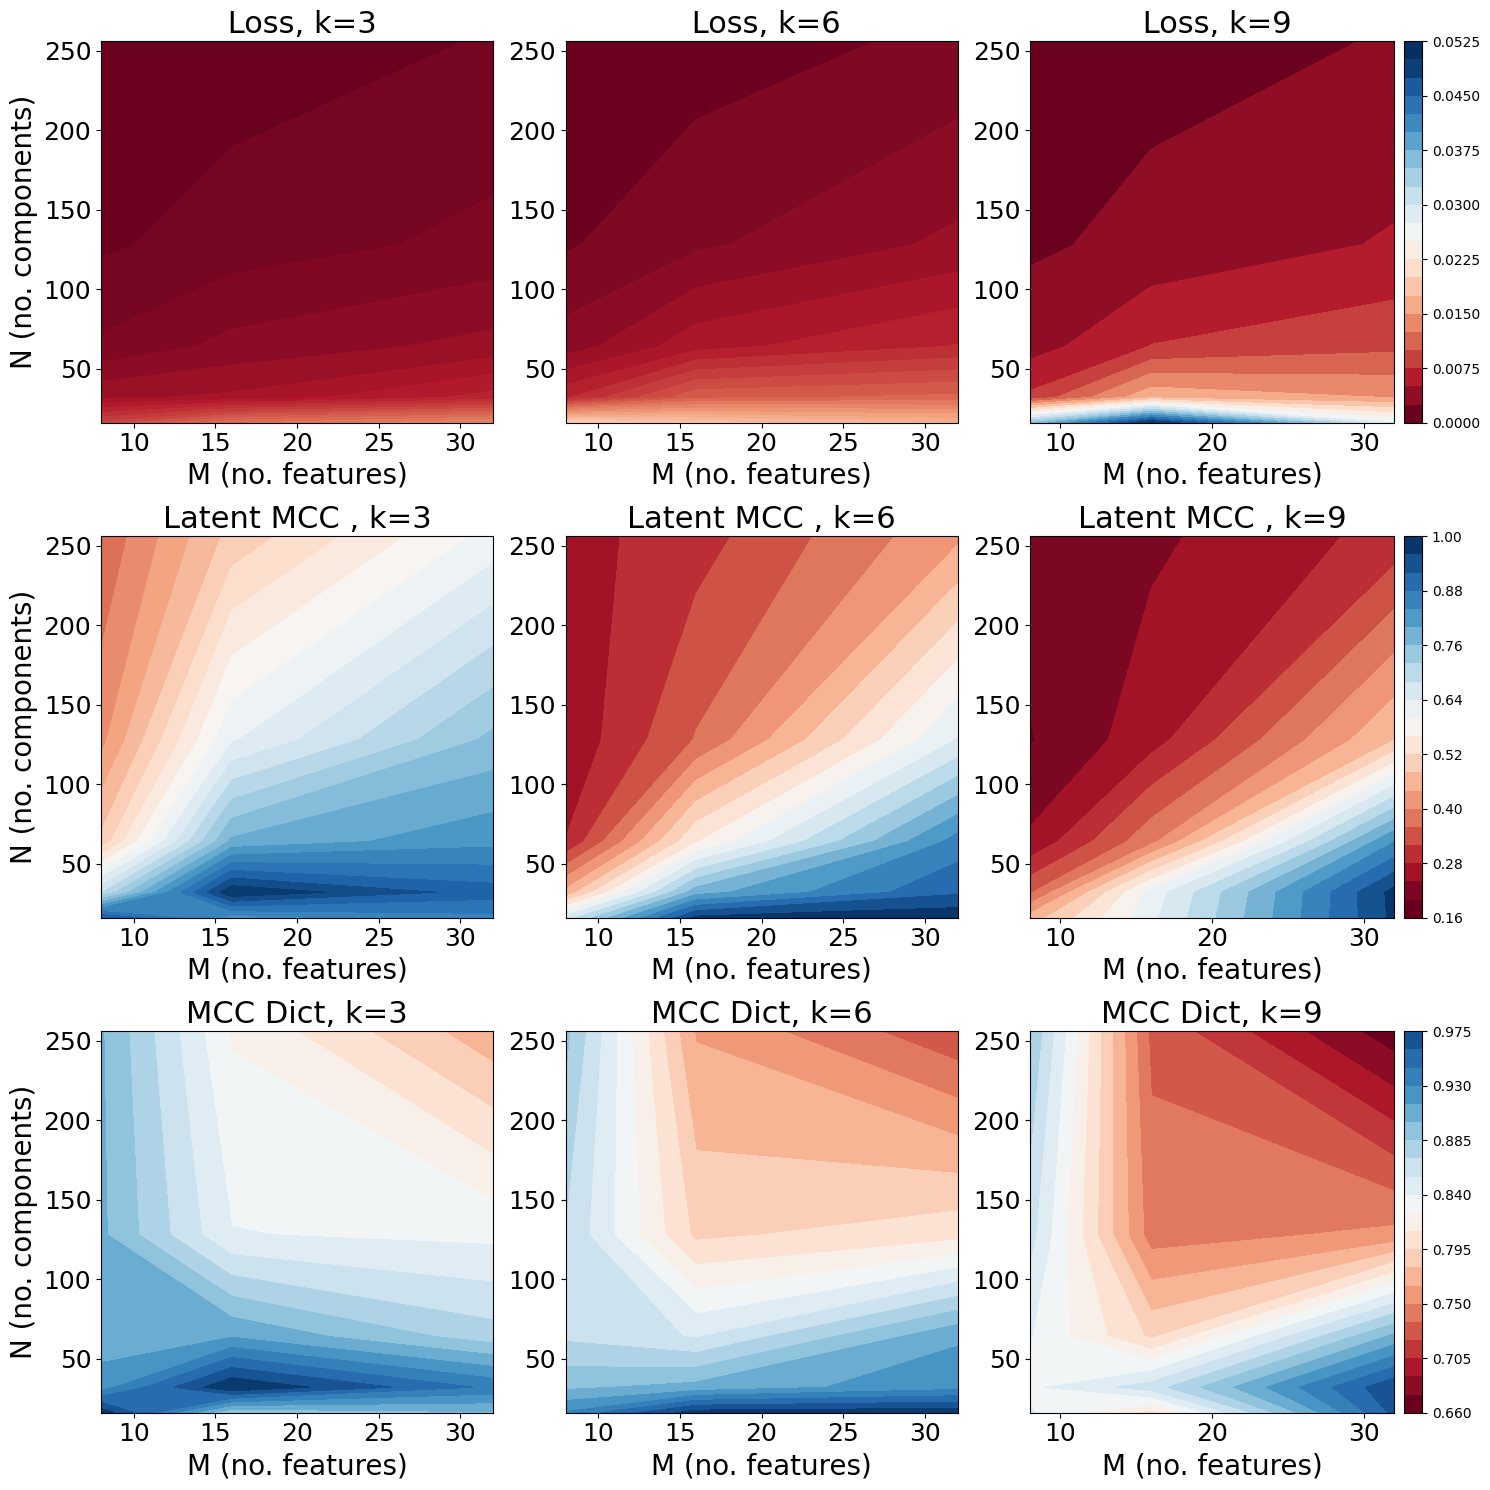

Contour plots have been saved as 'results/figures/dictionary_learning_contour_plots.pdf'


In [37]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the results from the JSON file
with open("results/dictionary_learning_results.json", "r") as f:
    results = json.load(f)

# Extract unique values for N, M, and k
N_values = sorted(set(int(key.split("_")[0][1:]) for key in results.keys()))
M_values = sorted(set(int(key.split("_")[1][1:]) for key in results.keys()))
k_values = sorted(set(int(key.split("_")[2][1:]) for key in results.keys()))

# Metrics to plot
metrics = ["test_loss", "mcc_test", "mcc_dict"]

# Set base font size
base_fontsize = 20

# Create a figure with subplots for each metric and k value
fig, axes = plt.subplots(len(metrics), len(k_values), figsize=(5*len(k_values), 5*len(metrics)), squeeze=False)

# Calculate min and max for each metric across all k values
metric_ranges = {metric: [float('inf'), float('-inf')] for metric in metrics}
for metric in metrics:
    for k in k_values:
        for N in N_values:
            for M in M_values:
                key = f"N{N}_M{M}_k{k}"
                if key in results:
                    value = results[key][metric]
                    metric_ranges[metric][0] = min(metric_ranges[metric][0], value)
                    metric_ranges[metric][1] = max(metric_ranges[metric][1], value)

for i, metric in enumerate(metrics):
    vmin, vmax = metric_ranges[metric]
    for j, k in enumerate(k_values):
        ax = axes[i, j]
        
        # Prepare data for contour plot
        Z = np.zeros((len(N_values), len(M_values)))
        for ii, N in enumerate(N_values):
            for jj, M in enumerate(M_values):
                key = f"N{N}_M{M}_k{k}"
                if key in results:
                    Z[ii, jj] = results[key][metric]
                else:
                    Z[ii, jj] = np.nan
        
        # Create contour plot
        X, Y = np.meshgrid(M_values, N_values)
        contour = ax.contourf(X, Y, Z, levels=20, cmap='RdBu', vmin=vmin, vmax=vmax)
        
        # Add colorbar only for the rightmost plot in each row
        if j == len(k_values) - 1:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = plt.colorbar(contour, cax=cax)
            # cbar.set_ticks([vmin, vmax])
            # cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])
        
        # Set labels and title
        metric_title = metric.replace("_", " ").title().replace('Test', '')
        if 'Mcc' in metric_title:
            metric_title = metric_title.replace('Mcc', 'MCC')
        if metric == 'mcc_test':
            metric_title = metric_title.replace('MCC', 'Latent MCC')
        ax.set_xlabel('M (no. features)', fontsize=base_fontsize)
        if j == 0:  # Only set y-label for leftmost plot in each row
            ax.set_ylabel('N (no. components)', fontsize=base_fontsize)
        ax.set_title(f'{metric_title}, k={k}', fontsize=base_fontsize+2)
        
        # Set tick label font size
        ax.tick_params(axis='both', which='major', labelsize=base_fontsize-2)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('results/figures/dictionary_learning_contour_plots.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Contour plots have been saved as 'results/figures/dictionary_learning_contour_plots.pdf'")

In [17]:
 # Generate data
S, X, D = generate_data(N, M, K, num_data, seed=run_seed)
D = D.T
S_train = S[:num_data]
X_train = X[:num_data]
S_test = S[num_data:]
X_test = X[num_data:]
D_true = D

# Print shapes
print(f"S shape = {S.shape}, X shape = {X.shape}, D shape = {D.shape}")

S shape = torch.Size([1024, 16]), X shape = torch.Size([1024, 8]), D shape = torch.Size([8, 16])


In [18]:
X

tensor([[ 0.8967, -0.7955,  0.3930,  ..., -0.1966,  1.0606,  0.4226],
        [ 1.2399, -0.6901, -0.2455,  ...,  0.9280, -0.7672,  0.0667],
        [-0.0271,  0.0201,  0.0558,  ...,  0.1043,  0.0275, -0.1364],
        ...,
        [-0.2910, -0.4150, -0.0800,  ..., -0.4768, -0.1806,  0.7771],
        [-0.7851,  0.2430, -0.8927,  ..., -0.7370, -0.2908,  0.5045],
        [-0.5560, -0.2886,  0.8085,  ..., -0.5420,  1.2806, -0.1112]])

In [2]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning, SparseCoder
from utils import reconstruction_loss_with_l1
import torch
from metrics import mcc, greedy_mcc


X, D, S = make_sparse_coded_signal(
    n_samples=1024, n_components=16, n_features=8, n_nonzero_coefs=3,
    random_state=42,
)
X_test, D_test, S_test = make_sparse_coded_signal(
    n_samples=1024, n_components=16, n_features=8, n_nonzero_coefs=3,
)

# Print shapes
print(f"S shape = {S.shape}, X shape = {X.shape}, D shape = {D.shape}")

print("Doing all training stuff...")

dict_learner = DictionaryLearning(
    n_components=16, transform_algorithm='omp', 
    random_state=42,
)

S_ = dict_learner.fit(X).transform(X)

l0 = np.mean(S_ == 0)
print(l0)

X_ = S_ @ dict_learner.components_
loss = reconstruction_loss_with_l1(torch.tensor(X_), torch.tensor(X), torch.tensor(S_), l1_weight=0.01)
print(loss)

# Calculate mcc (latents)
mcc_train = mcc(S, S_)
print(mcc_train)

# Calculate mcc (dictionary elements)
mcc_dict_train = mcc(D.T, dict_learner.components_.T)
print(mcc_dict_train)

print("\n\nDoing all testing stuff...")
coder = SparseCoder(
    dictionary=dict_learner.components_, transform_algorithm='omp',
)

S_test_ = coder.transform(X_test) # dict_learner.transform(X_test)
l0 = np.mean(S_test_ == 0)
print(l0)
X_test_ = S_test_ @ dict_learner.components_
loss = reconstruction_loss_with_l1(torch.tensor(X_test), torch.tensor(X_test_), torch.tensor(S_test_), l1_weight=0.01)
print(loss)
mcc_test = mcc(S_test, S_test_)
print(mcc_test)

S shape = (1024, 16), X shape = (1024, 8), D shape = (16, 8)
Doing all training stuff...
0.9375
tensor(0.0849, dtype=torch.float64)
0.7357957747948943
0.9857035131657326


Doing all testing stuff...
0.9375
tensor(0.2146, dtype=torch.float64)
0.3369175422628519


In [17]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning, SparseCoder
from utils import reconstruction_loss_with_l1
import torch
from metrics import mcc, greedy_mcc

l1_weight = 0.05
X, D, S = make_sparse_coded_signal(
    n_samples=1024*2, n_components=16, n_features=8, n_nonzero_coefs=3,
    random_state=42,
)
X_train = X[:1024]
X_test = X[1024:]
S_train = S[:1024]
S_test = S[1024:]

# Print shapes
print(f"S shape = {S.shape}, X shape = {X.shape}, D shape = {D.shape}")
print(f"S_train shape = {S_train.shape}, X_train shape = {X_train.shape}")
print(f"S_test shape = {S_test.shape}, X_test shape = {X_test.shape}")

print("Doing all training stuff...")

dict_learner = DictionaryLearning(
    n_components=16, transform_algorithm='lasso_lars', transform_alpha=l1_weight,
    random_state=42,
)

S_ = dict_learner.fit(X_train).transform(X_train)

l0 = np.mean(S_ == 0)
print(l0)

X_ = S_ @ dict_learner.components_
loss = reconstruction_loss_with_l1(torch.tensor(X_), torch.tensor(X_train), torch.tensor(S_), l1_weight=l1_weight)
print(loss)

# Calculate mcc (latents)
mcc_train = mcc(S_train, S_)
print(mcc_train)

# Calculate mcc (dictionary elements)
mcc_dict_train = mcc(D.T, dict_learner.components_.T)
print(mcc_dict_train)

print("\n\nDoing all testing stuff...")
coder = SparseCoder(
    dictionary=dict_learner.components_, transform_algorithm='lasso_lars', transform_alpha=l1_weight,
)

S_test_ = coder.transform(X_test)
l0 = np.mean(S_test_ == 0)
print(l0)
X_test_ = S_test_ @ dict_learner.components_
loss = reconstruction_loss_with_l1(torch.tensor(X_test), torch.tensor(X_test_), torch.tensor(S_test_), l1_weight=l1_weight)
print(loss)
mcc_test = mcc(S_test, S_test_)
print(mcc_test)

S shape = (2048, 16), X shape = (2048, 8), D shape = (16, 8)
S_train shape = (1024, 16), X_train shape = (1024, 8)
S_test shape = (1024, 16), X_test shape = (1024, 8)
Doing all training stuff...
0.64447021484375
tensor(0.0089, dtype=torch.float64)
0.9312338664660182
0.9857035131657326


Doing all testing stuff...
0.642578125
tensor(0.0090, dtype=torch.float64)
0.9318237439912267


## Bias

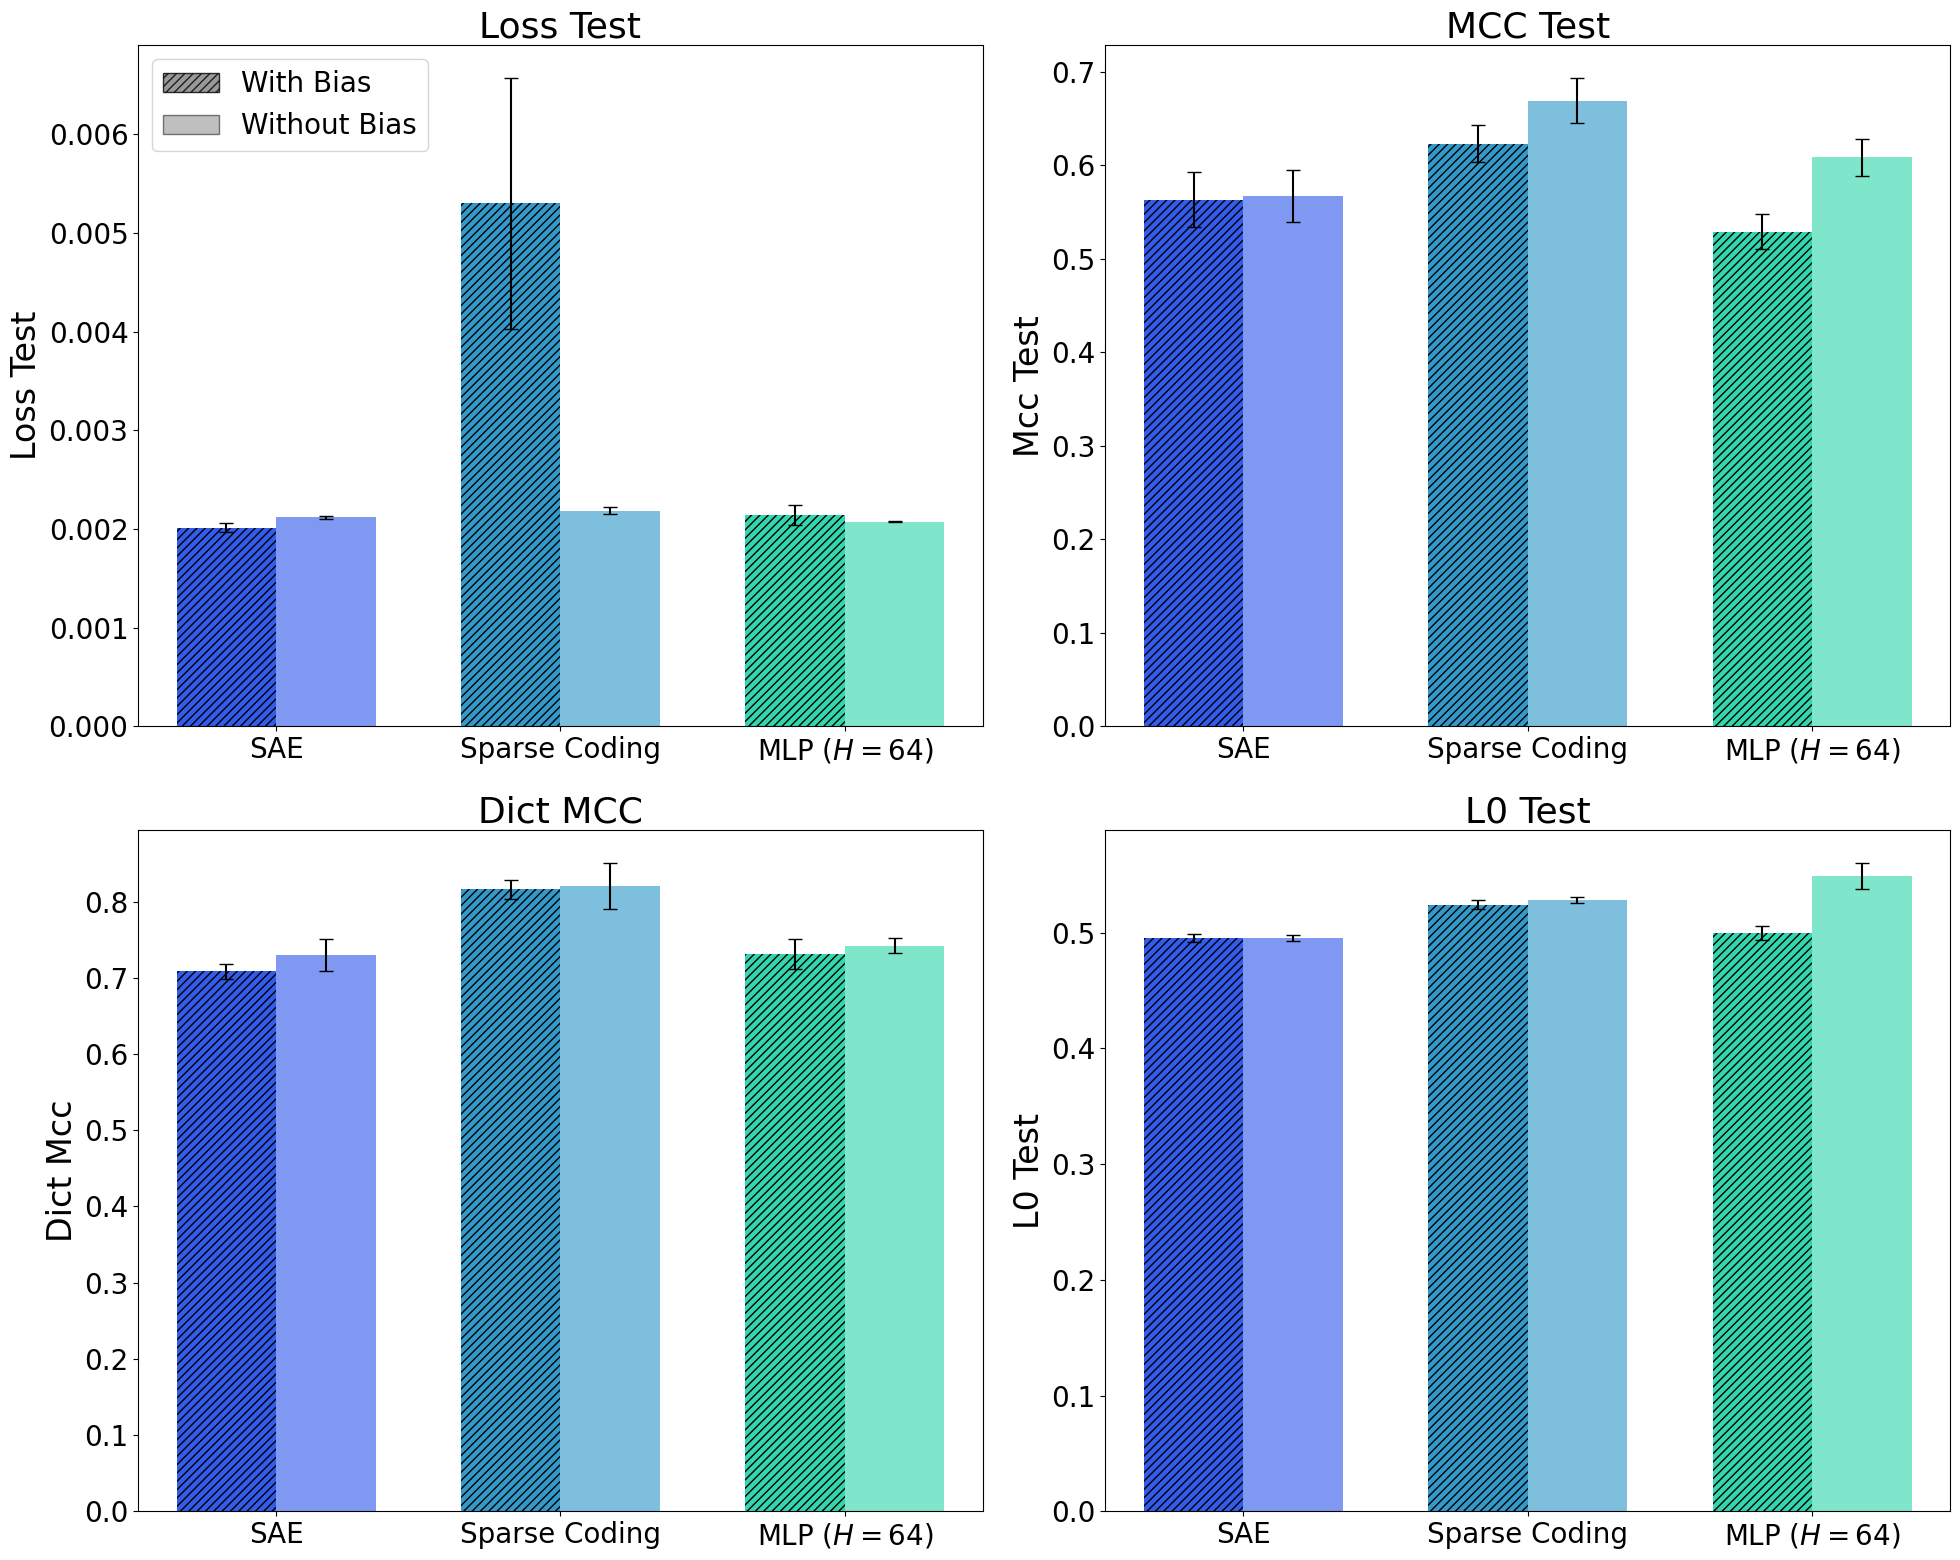

Plot saved as 'results/figures/bias_comparison_plot.pdf'.


In [60]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_bias_comparison(results, base_fontsize=12):
    plt.rcParams.update({'font.size': base_fontsize})

    metrics = ['loss_test', 'mcc_test', 'dict_mcc', 'l0_test']
    model_types = ['SAE', 'Sparse Coding', 'MLP ($H=64$)']
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    
    colors = plt.cm.winter(np.linspace(0.2, 0.8, len(model_types)))
    
    for i, metric in enumerate(metrics):
        ax = axs[i//2, i%2]
        
        x = np.arange(len(model_types))
        width = 0.35
        
        with_bias = []
        without_bias = []
        with_bias_err = []
        without_bias_err = []
        
        for j, model in enumerate(model_types):
            if model.startswith('MLP'):
                with_bias.append(results['MLP']['64']['with_bias'][metric])
                without_bias.append(results['MLP']['64']['without_bias'][metric])
                with_bias_err.append(results['MLP']['64']['with_bias'][f'{metric}_std'])
                without_bias_err.append(results['MLP']['64']['without_bias'][f'{metric}_std'])
            elif model == 'Sparse Coding':
                with_bias.append(results['SparseCoding']['with_bias'][metric])
                without_bias.append(results['SparseCoding']['without_bias'][metric])
                with_bias_err.append(results['SparseCoding']['with_bias'][f'{metric}_std'])
                without_bias_err.append(results['SparseCoding']['without_bias'][f'{metric}_std'])
            else:
                with_bias.append(results[model]['with_bias'][metric])
                without_bias.append(results[model]['without_bias'][metric])
                with_bias_err.append(results[model]['with_bias'][f'{metric}_std'])
                without_bias_err.append(results[model]['without_bias'][f'{metric}_std'])
        
        # Plot bars with different styles
        for j in range(len(model_types)):
            ax.bar(x[j] - width/2, with_bias[j], width, color=colors[j],
                   hatch='////', alpha=0.8)
            ax.bar(x[j] + width/2, without_bias[j], width, color=colors[j],
                   alpha=0.5)
        
        ax.errorbar(x - width/2, with_bias, yerr=with_bias_err, fmt='none', ecolor='k', capsize=5)
        ax.errorbar(x + width/2, without_bias, yerr=without_bias_err, fmt='none', ecolor='k', capsize=5)
        
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=base_fontsize*1.2)
        ax.set_xticks(x)
        ax.set_xticklabels(model_types, rotation=0)#, ha='right')
        if i == 0:  # Only add legend to the top-left plot
            # Create custom legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='gray', edgecolor='black', hatch='////', label='With Bias', alpha=0.8),
                Patch(facecolor='gray', edgecolor='black', label='Without Bias', alpha=0.5)
            ]
            ax.legend(handles=legend_elements, fontsize=base_fontsize*1.0, loc='upper left')
        sub_title = metric.replace("_", " ").title()
        # If Mcc in sub_title, turn it into MCC
        if 'Mcc' in sub_title:
            sub_title = sub_title.replace('Mcc', 'MCC')
        ax.set_title(f'{sub_title}', fontsize=base_fontsize*1.3)
    
    plt.tight_layout()
    plt.savefig('results/figures/bias_comparison_plot.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Load the results
with open('results/bias_comparison_results.json', 'r') as f:
    results = json.load(f)

# Create the plot
plot_bias_comparison(results, base_fontsize=20)

print("Plot saved as 'results/figures/bias_comparison_plot.pdf'.")

## Debugging

In [14]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('..')

# Assuming these functions are defined elsewhere
from experiments import generate_data
from metrics import mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
num_data = 1024
seed = 20240925
num_step = 20_000

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D, seed=20240925):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed)
        if learn_D:
            self.D = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D = nn.Parameter(data=D, requires_grad=False)
        self.log_S = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)

    def forward(self, X):
        if self.learn_D:
            self.D.data /= torch.linalg.norm(self.D.data, dim=1, keepdim=True)
        S = torch.exp(self.log_S)
        X_ = S @ self.D
        return S, X_

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.01):
    loss = torch.sum((X - X_) ** 2) + l1_weight * torch.sum(torch.abs(S_))
    return loss

def train_sparse_coding(model, X, S, num_step=30000):
    optim = torch.optim.Adam(model.parameters(), lr=3e-3)
    
    for i in range(num_step):
        S_, X_ = model(X)
        loss = reconstruction_loss_with_l1(X, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i % 1000 == 0:
            train_mcc = mcc(S.cpu().numpy(), S_.detach().cpu().numpy())
            print(f"Step {i}: Loss = {loss.item():.4f} Train MCC = {train_mcc:.4f}")
    
    return model

# Generate data
S, X, D = generate_data(N, M, K, num_data, seed=seed)

# Create and train the model
model = SparseCoding(X, D, learn_D=True, seed=seed).to(device)
trained_model = train_sparse_coding(model, X, S, num_step=num_step)

print("Training completed.")

Step 0: Loss = 3173.1597 Train MCC = 0.0000
Step 1000: Loss = 2773.8567 Train MCC = 0.3186
Step 2000: Loss = 165.3747 Train MCC = 0.5913
Step 3000: Loss = 44.0571 Train MCC = 0.6175
Step 4000: Loss = 37.1701 Train MCC = 0.6385
Step 5000: Loss = 34.4708 Train MCC = 0.6714
Step 6000: Loss = 32.7174 Train MCC = 0.6979
Step 7000: Loss = 31.4013 Train MCC = 0.7242


KeyboardInterrupt: 

In [4]:
# %%
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as corr
import pickle
from tqdm import tqdm
import sys
from munkres import Munkres
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gennorm
from typing import Union

from scipy.fft import dct

from metrics import mcc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

# %%
# parameters
N = 16  # number of sparse sources
K = 3  # number of active components
M = 8  # number of measurements
seed = 20240625
num_data = 1024
lr = 3e-3
num_step = 20000
weight = 1e-2


def criterion(S_, X, X_, weight=weight):
    loss = torch.sum((X - X_) ** 2) + weight * torch.sum(torch.abs(S_))
    return loss

class SparseCoding(nn.Module):
    def __init__(self, S, D, learn_D, seed=seed):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(S.shape), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_

def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model.forward(X)
        loss = criterion(S_, X, X_, weight=weight)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i > 0 and not i % 1000:
            # Print D_
            if not torch.all(S_.var(0) > 0):
                print('dead latents')
            print(f'step {i}, loss {loss.item():.4f}, '
                  f'MCC {mcc(S.detach().cpu().numpy(), S_.detach().cpu().numpy()):.4f}')
    print('final MCC', mcc(S.detach().cpu().numpy(), S_.detach().cpu().numpy()))
    return S_

torch.manual_seed(seed)
#S, X, D = generate_data(N, M, K, num_data, seed=seed)
print(S.shape, X.shape, D.shape)

# 
sc0 = SparseCoding(S, D, learn_D=True, seed=seed).to(device)
S_ = train(sc0)

using cpu
torch.Size([1024, 16]) torch.Size([1024, 8]) torch.Size([16, 8])
step 1000, loss 2759.4897, MCC 0.3050
step 2000, loss 186.3278, MCC 0.5560
step 3000, loss 46.5634, MCC 0.6061
step 4000, loss 37.8071, MCC 0.6511
step 5000, loss 34.3759, MCC 0.6934
step 6000, loss 32.1603, MCC 0.7402
step 7000, loss 30.2994, MCC 0.7939
step 8000, loss 28.4424, MCC 0.8491
step 9000, loss 27.1028, MCC 0.8810
step 10000, loss 26.6628, MCC 0.8899
step 11000, loss 26.9043, MCC 0.8891
step 12000, loss 27.5940, MCC 0.8935
step 13000, loss 27.8359, MCC 0.9000
step 14000, loss 28.3828, MCC 0.8921
step 15000, loss 28.8028, MCC 0.8779
step 16000, loss 29.0104, MCC 0.8608
step 17000, loss 29.4387, MCC 0.8375
step 18000, loss 29.7480, MCC 0.8097
step 19000, loss 29.7556, MCC 0.7936
final MCC 0.789343745392669


## Scaling laws

## Varying $N$ and $M$

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import SparseAutoEncoder, MLP, SparseCoding
from metrics import mcc, greedy_mcc
from utils import numpy_to_list, generate_data, reconstruction_loss_with_l1
from calculate_flops import (calculate_sae_training_flops, calculate_sae_inference_flops, 
                             calculate_mlp_training_flops, calculate_mlp_inference_flops, 
                             calculate_sparse_coding_training_flops, calculate_sparse_coding_inference_flops)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def run_experiment(model, X_train, S_train, X_test, S_test, D_true, num_step=100_000, log_step=2500):
    if isinstance(model, SparseCoding):
        return train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
    else:
        return train(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)

def train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=100_000, log_step=2500):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    best_mcc = 0
    for i in range(num_step):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % log_step == 0:
            S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
            mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            if mcc_test > best_mcc:
                best_mcc = mcc_test
            print(f'step {i}, loss {loss.item():.4f}, mcc test {mcc_test:.4f}')
    return best_mcc

def train(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=100):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    best_mcc = 0
    for i in range(num_step):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % log_step == 0:
            with torch.no_grad():
                S_, X_ = model(X_test)
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            if mcc_test > best_mcc:
                best_mcc = mcc_test
            print(f'step {i}, loss {loss.item():.4f}, mcc test {mcc_test:.4f}')
    return best_mcc

def scaling_laws_experiment(N_values, M_values, K, num_data=1024, num_step=30000, log_step=100, seed=20240927):
    results = {method: {M: [] for M in M_values} for method in ['SAE', 'MLP', 'SparseCoding']}
    
    for M in M_values:
        for N in N_values:
            torch.manual_seed(seed)
            np.random.seed(seed)

            print(f'N: {N}, M: {M}') 
            print('-' * 80)
            
            # Generate data
            S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
            S_train, X_train = S[:num_data].to(device), X[:num_data].to(device)
            S_test, X_test = S[num_data:].to(device), X[num_data:].to(device)
            D_true = D.to(device)

            # Sparse Coding
            print('SparseCoding')
            sc = SparseCoding(X_test, D=D_true, learn_D=True, seed=seed).to(device)
            sc_mcc = run_experiment(sc, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            results['SparseCoding'][M].append(sc_mcc)
            
            # SAE
            print('SAE')
            sae = SparseAutoEncoder(M, N, D=D_true, learn_D=True, seed=seed).to(device)
            sae_mcc = run_experiment(sae, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            results['SAE'][M].append(sae_mcc)
            
            # MLP (using hidden layer size of 256)
            print('MLP')
            mlp = MLP(M, N, h=256, D=D_true, learn_D=True, seed=seed).to(device)
            mlp_mcc = run_experiment(mlp, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            results['MLP'][M].append(mlp_mcc)
            
            print(f"Completed N={N}, M={M}")
    
    return results

# Parameters
N_values = [16, 32, 64, 128, 256]
M_values = [8, 16, 32]
K = 3
num_data = 1024
num_step = 100_000
log_step = 10_000
seed = 20240927

# Run experiment
results = scaling_laws_experiment(N_values, M_values, K, num_data, num_step, log_step, seed)

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import SparseAutoEncoder, MLP, SparseCoding
from metrics import mcc, greedy_mcc
from utils import numpy_to_list, generate_data, reconstruction_loss_with_l1
from calculate_flops import (calculate_sae_training_flops, calculate_sae_inference_flops, calculate_optimize_codes_flops,
                             calculate_mlp_training_flops, calculate_mlp_inference_flops, 
                             calculate_sparse_coding_training_flops, calculate_sparse_coding_inference_flops)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calculate_dict_mcc(D_true, D_learned):
    return greedy_mcc(D_true.cpu().numpy(), D_learned.cpu().numpy())

def run_experiment(model, X_train, S_train, X_test, S_test, D_true, num_step=100_000, log_step=2500):
    if isinstance(model, SparseCoding):
        return train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
    else:
        return train(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)

def train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, lr=3e-3, num_step=100_000, log_step=2500):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % log_step == 0:
            print(f'step {i}, loss {loss.item():.4f}')
    
    # Final evaluation
    S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
    mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
    dict_mcc = calculate_dict_mcc(D_true, model.D.data)
    
    # Calculate FLOPs
    train_flops = calculate_sparse_coding_training_flops(X_train.shape[1], model.D.shape[1], X_train.shape[0], num_step, learn_D=True)
    test_flops = calculate_optimize_codes_flops(X_test.shape[1], model.D.shape[1], X_test.shape[0], 10_000)
    
    print(f'Final mcc test {mcc_test:.4f}, dict mcc {dict_mcc:.4f}')
    return mcc_test, dict_mcc, train_flops, test_flops

def train(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=100_000, log_step=2500):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % log_step == 0:
            print(f'step {i}, loss {loss.item():.4f}')
    
    # Final evaluation
    with torch.no_grad():
        S_, X_ = model(X_test)
    mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
    dict_mcc = calculate_dict_mcc(D_true, model.decoder.weight.data)
    
    # Calculate FLOPs
    if isinstance(model, SparseAutoEncoder):
        train_flops = calculate_sae_training_flops(X_train.shape[1], model.decoder.weight.shape[1], X_train.shape[0], num_step, learn_D=True)
        test_flops = calculate_sae_inference_flops(X_test.shape[1], model.decoder.weight.shape[1], X_test.shape[0])
    elif isinstance(model, MLP):
        h = model.encoder[0].out_features
        train_flops = calculate_mlp_training_flops(X_train.shape[1], h, model.decoder.weight.shape[1], X_train.shape[0], num_step, learn_D=True)
        test_flops = calculate_mlp_inference_flops(X_test.shape[1], h, model.decoder.weight.shape[1], X_test.shape[0])
    
    print(f'Final mcc test {mcc_test:.4f}, dict mcc {dict_mcc:.4f}')
    return mcc_test, dict_mcc, train_flops, test_flops

def scaling_laws_experiment(N_values, M_values, K, num_data=1024, num_step=100_000, log_step=2500, seed=20240927, num_runs=3):
    results = {method: {M: [] for M in M_values} for method in ['SAE', 'MLP', 'SparseCoding']}
    
    for M in M_values:
        for N in tqdm(N_values, desc='N'):
            print(f'N: {N}, M: {M}') 
            print('-' * 80)
            
            sc_mccs, sc_dict_mccs = [], []
            sae_mccs, sae_dict_mccs = [], []
            mlp_mccs, mlp_dict_mccs = [], []
            
            for run in range(num_runs):
                print(f'Run {run + 1}/{num_runs}')
                run_seed = seed + run
                torch.manual_seed(run_seed)
                np.random.seed(run_seed)
                
                # Generate data
                S, X, D = generate_data(N, M, K, num_data * 2, seed=run_seed)
                D = D.T
                S_train, X_train = S[:num_data].to(device), X[:num_data].to(device)
                S_test, X_test = S[num_data:].to(device), X[num_data:].to(device)
                D_true = D.to(device)

                # MLP (using hidden layer size of 32)
                print('MLP')
                mlp = MLP(M, N, h=32, D=D_true, learn_D=True, seed=run_seed).to(device)
                mlp_mcc, mlp_dict_mcc, mlp_train_flops, mlp_test_flops = run_experiment(mlp, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
                mlp_mccs.append(mlp_mcc)
                mlp_dict_mccs.append(mlp_dict_mcc)

                # Sparse Coding
                print('SparseCoding')
                sc = SparseCoding(X_test, D=D_true, learn_D=True, seed=run_seed).to(device)
                sc_mcc, sc_dict_mcc, sc_train_flops, sc_test_flops = run_experiment(sc, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
                sc_mccs.append(sc_mcc)
                sc_dict_mccs.append(sc_dict_mcc)
                
                # SAE
                print('SAE')
                sae = SparseAutoEncoder(M, N, D=D_true, learn_D=True, seed=run_seed).to(device)
                sae_mcc, sae_dict_mcc, sae_train_flops, sae_test_flops = run_experiment(sae, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
                sae_mccs.append(sae_mcc)
                sae_dict_mccs.append(sae_dict_mcc)
            
            # Average MCCs and store results
            results['SparseCoding'][M].append((N, np.mean(sc_mccs), np.std(sc_mccs), np.mean(sc_dict_mccs), np.std(sc_dict_mccs), sc_train_flops, sc_test_flops))
            results['SAE'][M].append((N, np.mean(sae_mccs), np.std(sae_mccs), np.mean(sae_dict_mccs), np.std(sae_dict_mccs), sae_train_flops, sae_test_flops))
            results['MLP'][M].append((N, np.mean(mlp_mccs), np.std(mlp_mccs), np.mean(mlp_dict_mccs), np.std(mlp_dict_mccs), mlp_train_flops, mlp_test_flops))
            
            print(f"Completed N={N}, M={M}")
    
    return results

# Parameters
N_values = [16, 32, 64, 128]
M_values = [8, 16, 32]
K = 3
num_data = 1024
num_step = 50_000
log_step = 25_000
seed = 20240927
num_runs = 3

# Run experiment
results = scaling_laws_experiment(N_values, M_values, K, num_data, num_step, log_step, seed, num_runs)

# Save results
with open(f'results/scaling_laws_K_{K}.json', 'w') as f:
    json.dump(results, f, indent=2)

Total FLOPs for training: 1049559040000
Total FLOPs for inference: 278912


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 8
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([8, 16])
MLP decoder shape = torch.Size([8, 16])
step 0, loss 0.3856
step 25000, loss 0.0021
Final mcc test 0.5513, dict mcc 0.7699
SparseCoding
step 0, loss 0.3670
step 25000, loss 0.0019
Final mcc test 0.7735, dict mcc 0.9227
SAE
SAE decoder shape = torch.Size([8, 16])
SAE decoder shape = torch.Size([8, 16])
step 0, loss 0.5250
step 25000, loss 0.0020
Final mcc test 0.6260, dict mcc 0.7462
Run 2/3
MLP
MLP decoder shape = torch.Size([8, 16])
MLP decoder shape = torch.Size([8, 16])
step 0, loss 0.4134
step 25000, loss 0.0021
Final mcc test 0.5807, dict mcc 0.7998
SparseCoding
step 0, loss 0.3959
step 25000, loss 0.0020
Final mcc test 0.7161, dict mcc 0.8529
SAE
SAE decoder shape = torch.Size([8, 16])
SAE decoder shape = torch.Size([8, 16])
step 0, loss 0.4982
step 25000, loss 0.0021
Final mcc test 0.6017, dict mcc 0.7045
Run 3/3
MLP
MLP decoder shape =

N:  25%|██▌       | 1/4 [02:17<06:51, 137.03s/it]

Final mcc test 0.6870, dict mcc 0.7860
Completed N=16, M=8
N: 32, M: 8
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([8, 32])
MLP decoder shape = torch.Size([8, 32])
step 0, loss 0.4491
step 25000, loss 0.0010
Final mcc test 0.4901, dict mcc 0.8079
SparseCoding
step 0, loss 0.3609
step 25000, loss 0.0009
Final mcc test 0.5238, dict mcc 0.8183
SAE
SAE decoder shape = torch.Size([8, 32])
SAE decoder shape = torch.Size([8, 32])
step 0, loss 0.7232
step 25000, loss 0.0010
Final mcc test 0.3703, dict mcc 0.7515
Run 2/3
MLP
MLP decoder shape = torch.Size([8, 32])
MLP decoder shape = torch.Size([8, 32])
step 0, loss 0.4012
step 25000, loss 0.0010
Final mcc test 0.4013, dict mcc 0.8045
SparseCoding
step 0, loss 0.3634
step 25000, loss 0.0009
Final mcc test 0.5343, dict mcc 0.8180
SAE
SAE decoder shape = torch.Size([8, 32])
SAE decoder shape = torch.Size([8, 32])
step 0, loss 0.5205
step 25000, loss 0.0010
Final mcc t

N:  50%|█████     | 2/4 [05:07<05:13, 156.75s/it]

Final mcc test 0.4171, dict mcc 0.7806
Completed N=32, M=8
N: 64, M: 8
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([8, 64])
MLP decoder shape = torch.Size([8, 64])
step 0, loss 0.4833
step 25000, loss 0.0005
Final mcc test 0.2880, dict mcc 0.8141
SparseCoding
step 0, loss 0.3784
step 25000, loss 0.0004
Final mcc test 0.4218, dict mcc 0.8397
SAE
SAE decoder shape = torch.Size([8, 64])
SAE decoder shape = torch.Size([8, 64])
step 0, loss 1.3944
step 25000, loss 0.0005
Final mcc test 0.2532, dict mcc 0.7908
Run 2/3
MLP
MLP decoder shape = torch.Size([8, 64])
MLP decoder shape = torch.Size([8, 64])
step 0, loss 0.4504
step 25000, loss 0.0005
Final mcc test 0.2880, dict mcc 0.8087
SparseCoding
step 0, loss 0.3963
step 25000, loss 0.0004
Final mcc test 0.4193, dict mcc 0.8423
SAE
SAE decoder shape = torch.Size([8, 64])
SAE decoder shape = torch.Size([8, 64])
step 0, loss 1.1659
step 25000, loss 0.0005
Final mcc t

N:  75%|███████▌  | 3/4 [10:28<03:51, 231.87s/it]

Final mcc test 0.2443, dict mcc 0.8080
Completed N=64, M=8
N: 128, M: 8
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([8, 128])
MLP decoder shape = torch.Size([8, 128])
step 0, loss 0.5468
step 25000, loss 0.0003
Final mcc test 0.2330, dict mcc 0.8195
SparseCoding
step 0, loss 0.3761
step 25000, loss 0.0002
Final mcc test 0.3241, dict mcc 0.8693
SAE
SAE decoder shape = torch.Size([8, 128])
SAE decoder shape = torch.Size([8, 128])
step 0, loss 1.6426
step 25000, loss 0.0003
Final mcc test 0.2109, dict mcc 0.8330
Run 2/3
MLP
MLP decoder shape = torch.Size([8, 128])
MLP decoder shape = torch.Size([8, 128])
step 0, loss 0.9891
step 25000, loss 0.0003
Final mcc test 0.2518, dict mcc 0.8263
SparseCoding
step 0, loss 0.3705
step 25000, loss 0.0002
Final mcc test 0.3341, dict mcc 0.8704
SAE
SAE decoder shape = torch.Size([8, 128])
SAE decoder shape = torch.Size([8, 128])
step 0, loss 2.0746
step 25000, loss 0.0003
Fi

N: 100%|██████████| 4/4 [19:25<00:00, 291.48s/it]


Final mcc test 0.2285, dict mcc 0.8394
Completed N=128, M=8


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 16
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([16, 16])
MLP decoder shape = torch.Size([16, 16])
step 0, loss 0.1883
step 25000, loss 0.0015
Final mcc test 0.9999, dict mcc 1.0000
SparseCoding
step 0, loss 0.1810
step 25000, loss 0.0015
Final mcc test 0.9778, dict mcc 0.9999
SAE
SAE decoder shape = torch.Size([16, 16])
SAE decoder shape = torch.Size([16, 16])
step 0, loss 0.2188
step 25000, loss 0.0022
Final mcc test 0.8794, dict mcc 0.9151
Run 2/3
MLP
MLP decoder shape = torch.Size([16, 16])
MLP decoder shape = torch.Size([16, 16])
step 0, loss 0.2178
step 25000, loss 0.0023
Final mcc test 0.7678, dict mcc 0.8691
SparseCoding
step 0, loss 0.1927
step 25000, loss 0.0016
Final mcc test 0.9714, dict mcc 0.9998
SAE
SAE decoder shape = torch.Size([16, 16])
SAE decoder shape = torch.Size([16, 16])
step 0, loss 0.2157
step 25000, loss 0.0015
Final mcc test 0.9938, dict mcc 0.9922
Run 3/3
MLP
MLP decode

N:  25%|██▌       | 1/4 [02:29<07:29, 149.80s/it]

Final mcc test 0.9997, dict mcc 0.9996
Completed N=16, M=16
N: 32, M: 16
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([16, 32])
MLP decoder shape = torch.Size([16, 32])
step 0, loss 0.2122
step 25000, loss 0.0014
Final mcc test 0.6031, dict mcc 0.7359
SparseCoding
step 0, loss 0.1886
step 25000, loss 0.0011
Final mcc test 0.8518, dict mcc 0.9179
SAE
SAE decoder shape = torch.Size([16, 32])
SAE decoder shape = torch.Size([16, 32])
step 0, loss 0.2883
step 25000, loss 0.0017
Final mcc test 0.5434, dict mcc 0.6762
Run 2/3
MLP
MLP decoder shape = torch.Size([16, 32])
MLP decoder shape = torch.Size([16, 32])
step 0, loss 0.1808
step 25000, loss 0.0015
Final mcc test 0.4949, dict mcc 0.6666
SparseCoding
step 0, loss 0.1782
step 25000, loss 0.0008
Final mcc test 0.9675, dict mcc 1.0000
SAE
SAE decoder shape = torch.Size([16, 32])
SAE decoder shape = torch.Size([16, 32])
step 0, loss 0.2244
step 25000, loss 0.0013
F

N:  50%|█████     | 2/4 [05:45<05:53, 176.66s/it]

Final mcc test 0.6024, dict mcc 0.6820
Completed N=32, M=16
N: 64, M: 16
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([16, 64])
MLP decoder shape = torch.Size([16, 64])
step 0, loss 0.2197
step 25000, loss 0.0008
Final mcc test 0.3756, dict mcc 0.6650
SparseCoding
step 0, loss 0.1912
step 25000, loss 0.0006
Final mcc test 0.6711, dict mcc 0.8263
SAE
SAE decoder shape = torch.Size([16, 64])
SAE decoder shape = torch.Size([16, 64])
step 0, loss 0.3522
step 25000, loss 0.0007
Final mcc test 0.3710, dict mcc 0.6582
Run 2/3
MLP
MLP decoder shape = torch.Size([16, 64])
MLP decoder shape = torch.Size([16, 64])
step 0, loss 0.2593
step 25000, loss 0.0007
Final mcc test 0.4192, dict mcc 0.6770
SparseCoding
step 0, loss 0.1928
step 25000, loss 0.0006
Final mcc test 0.6571, dict mcc 0.8134
SAE
SAE decoder shape = torch.Size([16, 64])
SAE decoder shape = torch.Size([16, 64])
step 0, loss 0.3471
step 25000, loss 0.0007
F

N:  75%|███████▌  | 3/4 [11:50<04:22, 262.90s/it]

Final mcc test 0.3989, dict mcc 0.6673
Completed N=64, M=16
N: 128, M: 16
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([16, 128])
MLP decoder shape = torch.Size([16, 128])
step 0, loss 0.2815
step 25000, loss 0.0004
Final mcc test 0.2672, dict mcc 0.6494
SparseCoding
step 0, loss 0.1894
step 25000, loss 0.0003
Final mcc test 0.4831, dict mcc 0.7519
SAE
SAE decoder shape = torch.Size([16, 128])
SAE decoder shape = torch.Size([16, 128])
step 0, loss 0.5312
step 25000, loss 0.0004
Final mcc test 0.2754, dict mcc 0.6602
Run 2/3
MLP
MLP decoder shape = torch.Size([16, 128])
MLP decoder shape = torch.Size([16, 128])
step 0, loss 0.2776
step 25000, loss 0.0004
Final mcc test 0.3011, dict mcc 0.6533
SparseCoding
step 0, loss 0.1838
step 25000, loss 0.0003
Final mcc test 0.4643, dict mcc 0.7630
SAE
SAE decoder shape = torch.Size([16, 128])
SAE decoder shape = torch.Size([16, 128])
step 0, loss 0.4480
step 25000, loss

N: 100%|██████████| 4/4 [21:11<00:00, 317.76s/it]


Final mcc test 0.2834, dict mcc 0.6648
Completed N=128, M=16


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 32
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([32, 16])
MLP decoder shape = torch.Size([32, 16])
step 0, loss 0.0948
step 25000, loss 0.0027
Final mcc test 0.8732, dict mcc 0.9377
SparseCoding
step 0, loss 0.0897
step 25000, loss 0.0015
Final mcc test 0.9413, dict mcc 0.9998
SAE
SAE decoder shape = torch.Size([32, 16])
SAE decoder shape = torch.Size([32, 16])
step 0, loss 0.1028
step 25000, loss 0.0015
Final mcc test 0.9999, dict mcc 0.9998
Run 2/3
MLP
MLP decoder shape = torch.Size([32, 16])
MLP decoder shape = torch.Size([32, 16])
step 0, loss 0.1093
step 25000, loss 0.0015
Final mcc test 0.9999, dict mcc 0.9999
SparseCoding
step 0, loss 0.0983
step 25000, loss 0.0015
Final mcc test 0.9415, dict mcc 0.9997
SAE
SAE decoder shape = torch.Size([32, 16])
SAE decoder shape = torch.Size([32, 16])
step 0, loss 0.1088
step 25000, loss 0.0015
Final mcc test 0.9999, dict mcc 0.9998
Run 3/3
MLP
MLP decode

N:  25%|██▌       | 1/4 [02:35<07:46, 155.49s/it]

Final mcc test 1.0000, dict mcc 0.9999
Completed N=16, M=32
N: 32, M: 32
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([32, 32])
MLP decoder shape = torch.Size([32, 32])
step 0, loss 0.1039
step 25000, loss 0.0009
Final mcc test 0.9326, dict mcc 0.9641
SparseCoding
step 0, loss 0.0944
step 25000, loss 0.0008
Final mcc test 0.9449, dict mcc 1.0000
SAE
SAE decoder shape = torch.Size([32, 32])
SAE decoder shape = torch.Size([32, 32])
step 0, loss 0.1156
step 25000, loss 0.0008
Final mcc test 0.9996, dict mcc 1.0000
Run 2/3
MLP
MLP decoder shape = torch.Size([32, 32])
MLP decoder shape = torch.Size([32, 32])
step 0, loss 0.0955
step 25000, loss 0.0010
Final mcc test 0.8675, dict mcc 0.9301
SparseCoding
step 0, loss 0.0882
step 25000, loss 0.0007
Final mcc test 0.9500, dict mcc 0.9999
SAE
SAE decoder shape = torch.Size([32, 32])
SAE decoder shape = torch.Size([32, 32])
step 0, loss 0.1148
step 25000, loss 0.0007
F

N:  50%|█████     | 2/4 [05:31<05:34, 167.40s/it]

Final mcc test 0.9980, dict mcc 0.9992
Completed N=32, M=32
N: 64, M: 32
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([32, 64])
MLP decoder shape = torch.Size([32, 64])
step 0, loss 0.1090
step 25000, loss 0.0015
Final mcc test 0.4053, dict mcc 0.5886
SparseCoding
step 0, loss 0.0953
step 25000, loss 0.0005
Final mcc test 0.9029, dict mcc 0.9674
SAE
SAE decoder shape = torch.Size([32, 64])
SAE decoder shape = torch.Size([32, 64])
step 0, loss 0.1586
step 25000, loss 0.0009
Final mcc test 0.5785, dict mcc 0.6643
Run 2/3
MLP
MLP decoder shape = torch.Size([32, 64])
MLP decoder shape = torch.Size([32, 64])
step 0, loss 0.1186
step 25000, loss 0.0015
Final mcc test 0.4091, dict mcc 0.5974
SparseCoding
step 0, loss 0.0971
step 25000, loss 0.0005
Final mcc test 0.9117, dict mcc 0.9721
SAE
SAE decoder shape = torch.Size([32, 64])
SAE decoder shape = torch.Size([32, 64])
step 0, loss 0.1346
step 25000, loss 0.0013
F

N:  75%|███████▌  | 3/4 [10:57<04:00, 240.09s/it]

Final mcc test 0.5718, dict mcc 0.6491
Completed N=64, M=32
N: 128, M: 32
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([32, 128])
MLP decoder shape = torch.Size([32, 128])
step 0, loss 0.1307
step 25000, loss 0.0009
Final mcc test 0.3019, dict mcc 0.5091
SparseCoding
step 0, loss 0.0944
step 25000, loss 0.0003
Final mcc test 0.8916, dict mcc 0.9630
SAE
SAE decoder shape = torch.Size([32, 128])
SAE decoder shape = torch.Size([32, 128])
step 0, loss 0.1849
step 25000, loss 0.0005
Final mcc test 0.4128, dict mcc 0.6060
Run 2/3
MLP
MLP decoder shape = torch.Size([32, 128])
MLP decoder shape = torch.Size([32, 128])
step 0, loss 0.1160
step 25000, loss 0.0007
Final mcc test 0.3404, dict mcc 0.5325
SparseCoding
step 0, loss 0.0935
step 25000, loss 0.0004
Final mcc test 0.8529, dict mcc 0.9343
SAE
SAE decoder shape = torch.Size([32, 128])
SAE decoder shape = torch.Size([32, 128])
step 0, loss 0.1772
step 25000, loss

N: 100%|██████████| 4/4 [21:05<00:00, 316.45s/it]

Final mcc test 0.4222, dict mcc 0.6094
Completed N=128, M=32


In [3]:
# Parameters
N_values = [16, 32, 64, 128]
M_values = [8, 16, 32]
K = 9
num_data = 1024
num_step = 50_000
log_step = 25_000
seed = 20240927
num_runs = 3

# Run experiment
results = scaling_laws_experiment(N_values, M_values, K, num_data, num_step, log_step, seed, num_runs)

# Save results
with open(f'results/scaling_laws_K_{K}.json', 'w') as f:
    json.dump(results, f, indent=2)

N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 8
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([8, 16])
MLP decoder shape = torch.Size([8, 16])
step 0, loss 1.1118
step 25000, loss 0.0037
Final mcc test 0.4900, dict mcc 0.7671
SparseCoding
step 0, loss 1.0859
step 25000, loss 0.0036
Final mcc test 0.5077, dict mcc 0.7549
SAE
SAE decoder shape = torch.Size([8, 16])
SAE decoder shape = torch.Size([8, 16])
step 0, loss 1.3890
step 25000, loss 0.0038
Final mcc test 0.4774, dict mcc 0.6917
Run 2/3
MLP
MLP decoder shape = torch.Size([8, 16])
MLP decoder shape = torch.Size([8, 16])
step 0, loss 1.3240
step 25000, loss 0.0039
Final mcc test 0.4988, dict mcc 0.7749
SparseCoding
step 0, loss 1.3307
step 25000, loss 0.0036
Final mcc test 0.4958, dict mcc 0.7801
SAE
SAE decoder shape = torch.Size([8, 16])
SAE decoder shape = torch.Size([8, 16])
step 0, loss 1.5915
step 25000, loss 0.0039
Final mcc test 0.4778, dict mcc 0.7494
Run 3/3
MLP
MLP decoder shape =

N:  25%|██▌       | 1/4 [02:26<07:18, 146.30s/it]

Final mcc test 0.5219, dict mcc 0.7714
Completed N=16, M=8
N: 32, M: 8
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([8, 32])
MLP decoder shape = torch.Size([8, 32])
step 0, loss 1.2590
step 25000, loss 0.0018
Final mcc test 0.3551, dict mcc 0.7349
SparseCoding
step 0, loss 1.1219
step 25000, loss 0.0016
Final mcc test 0.3687, dict mcc 0.7737
SAE
SAE decoder shape = torch.Size([8, 32])
SAE decoder shape = torch.Size([8, 32])
step 0, loss 2.2305
step 25000, loss 0.0019
Final mcc test 0.2677, dict mcc 0.7360
Run 2/3
MLP
MLP decoder shape = torch.Size([8, 32])
MLP decoder shape = torch.Size([8, 32])
step 0, loss 1.1680
step 25000, loss 0.0018
Final mcc test 0.2951, dict mcc 0.7372
SparseCoding
step 0, loss 1.1803
step 25000, loss 0.0016
Final mcc test 0.3824, dict mcc 0.7959
SAE
SAE decoder shape = torch.Size([8, 32])
SAE decoder shape = torch.Size([8, 32])
step 0, loss 1.5387
step 25000, loss 0.0020
Final mcc t

N:  50%|█████     | 2/4 [05:36<05:43, 171.97s/it]

Final mcc test 0.2848, dict mcc 0.7735
Completed N=32, M=8
N: 64, M: 8
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([8, 64])
MLP decoder shape = torch.Size([8, 64])
step 0, loss 1.4523
step 25000, loss 0.0010
Final mcc test 0.2307, dict mcc 0.7823
SparseCoding
step 0, loss 1.1125
step 25000, loss 0.0007
Final mcc test 0.2984, dict mcc 0.8163
SAE
SAE decoder shape = torch.Size([8, 64])
SAE decoder shape = torch.Size([8, 64])
step 0, loss 3.4666
step 25000, loss 0.0010
Final mcc test 0.2208, dict mcc 0.7919
Run 2/3
MLP
MLP decoder shape = torch.Size([8, 64])
MLP decoder shape = torch.Size([8, 64])
step 0, loss 1.4556
step 25000, loss 0.0010
Final mcc test 0.2371, dict mcc 0.7866
SparseCoding
step 0, loss 1.2335
step 25000, loss 0.0007
Final mcc test 0.3002, dict mcc 0.8069
SAE
SAE decoder shape = torch.Size([8, 64])
SAE decoder shape = torch.Size([8, 64])
step 0, loss 3.2753
step 25000, loss 0.0010
Final mcc t

N:  75%|███████▌  | 3/4 [11:57<04:27, 267.39s/it]

Final mcc test 0.2145, dict mcc 0.7817
Completed N=64, M=8
N: 128, M: 8
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([8, 128])
MLP decoder shape = torch.Size([8, 128])
step 0, loss 1.5071
step 25000, loss 0.0005
Final mcc test 0.1816, dict mcc 0.8006
SparseCoding
step 0, loss 1.1236
step 25000, loss 0.0003
Final mcc test 0.2458, dict mcc 0.8524
SAE
SAE decoder shape = torch.Size([8, 128])
SAE decoder shape = torch.Size([8, 128])
step 0, loss 4.5832
step 25000, loss 0.0005
Final mcc test 0.1698, dict mcc 0.8239
Run 2/3
MLP
MLP decoder shape = torch.Size([8, 128])
MLP decoder shape = torch.Size([8, 128])
step 0, loss 2.2018
step 25000, loss 0.0005
Final mcc test 0.1836, dict mcc 0.8173
SparseCoding
step 0, loss 1.1148
step 25000, loss 0.0003
Final mcc test 0.2414, dict mcc 0.8447
SAE
SAE decoder shape = torch.Size([8, 128])
SAE decoder shape = torch.Size([8, 128])
step 0, loss 4.9327
step 25000, loss 0.0005
Fi

N: 100%|██████████| 4/4 [21:22<00:00, 320.56s/it]


Final mcc test 0.1757, dict mcc 0.8350
Completed N=128, M=8


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 16
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([16, 16])
MLP decoder shape = torch.Size([16, 16])
step 0, loss 0.5297
step 25000, loss 0.0071
Final mcc test 0.7880, dict mcc 0.8751
SparseCoding
step 0, loss 0.5275
step 25000, loss 0.0046
Final mcc test 0.9108, dict mcc 0.9931
SAE
SAE decoder shape = torch.Size([16, 16])
SAE decoder shape = torch.Size([16, 16])
step 0, loss 0.5882
step 25000, loss 0.0066
Final mcc test 0.8228, dict mcc 0.8879
Run 2/3
MLP
MLP decoder shape = torch.Size([16, 16])
MLP decoder shape = torch.Size([16, 16])
step 0, loss 0.6823
step 25000, loss 0.0333
Final mcc test 0.3790, dict mcc 0.6618
SparseCoding
step 0, loss 0.5804
step 25000, loss 0.0054
Final mcc test 0.8416, dict mcc 0.9490
SAE
SAE decoder shape = torch.Size([16, 16])
SAE decoder shape = torch.Size([16, 16])
step 0, loss 0.5500
step 25000, loss 0.0049
Final mcc test 0.9953, dict mcc 0.9951
Run 3/3
MLP
MLP decode

N:  25%|██▌       | 1/4 [04:41<14:04, 281.43s/it]

Final mcc test 0.8566, dict mcc 0.8898
Completed N=16, M=16
N: 32, M: 16
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([16, 32])
MLP decoder shape = torch.Size([16, 32])
step 0, loss 0.6551
step 25000, loss 0.0040
Final mcc test 0.4848, dict mcc 0.6676
SparseCoding
step 0, loss 0.5901
step 25000, loss 0.0027
Final mcc test 0.4764, dict mcc 0.6743
SAE
SAE decoder shape = torch.Size([16, 32])
SAE decoder shape = torch.Size([16, 32])
step 0, loss 0.8823
step 25000, loss 0.0038
Final mcc test 0.5016, dict mcc 0.6634
Run 2/3
MLP
MLP decoder shape = torch.Size([16, 32])
MLP decoder shape = torch.Size([16, 32])
step 0, loss 0.5444
step 25000, loss 0.0045
Final mcc test 0.4538, dict mcc 0.6849
SparseCoding
step 0, loss 0.5828
step 25000, loss 0.0027
Final mcc test 0.4596, dict mcc 0.6625
SAE
SAE decoder shape = torch.Size([16, 32])
SAE decoder shape = torch.Size([16, 32])
step 0, loss 0.6630
step 25000, loss 0.0040
F

N:  50%|█████     | 2/4 [3:45:29<4:23:38, 7909.03s/it]

Final mcc test 0.4940, dict mcc 0.6565
Completed N=32, M=16
N: 64, M: 16
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([16, 64])
MLP decoder shape = torch.Size([16, 64])
step 0, loss 0.5928
step 25000, loss 0.0017
Final mcc test 0.3045, dict mcc 0.6104
SparseCoding
step 0, loss 0.5547
step 25000, loss 0.0012
Final mcc test 0.3508, dict mcc 0.6685
SAE
SAE decoder shape = torch.Size([16, 64])
SAE decoder shape = torch.Size([16, 64])
step 0, loss 0.9246
step 25000, loss 0.0013
Final mcc test 0.2859, dict mcc 0.6304
Run 2/3
MLP
MLP decoder shape = torch.Size([16, 64])
MLP decoder shape = torch.Size([16, 64])
step 0, loss 0.7055
step 25000, loss 0.0019
Final mcc test 0.2876, dict mcc 0.5614
SparseCoding
step 0, loss 0.5521
step 25000, loss 0.0012
Final mcc test 0.3514, dict mcc 0.6647
SAE
SAE decoder shape = torch.Size([16, 64])
SAE decoder shape = torch.Size([16, 64])
step 0, loss 0.8989
step 25000, loss 0.0013
F

N:  75%|███████▌  | 3/4 [3:53:23<1:15:14, 4514.11s/it]

Final mcc test 0.3135, dict mcc 0.6649
Completed N=64, M=16
N: 128, M: 16
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([16, 128])
MLP decoder shape = torch.Size([16, 128])
step 0, loss 0.7191
step 25000, loss 0.0007
Final mcc test 0.2208, dict mcc 0.6207
SparseCoding
step 0, loss 0.5496
step 25000, loss 0.0005
Final mcc test 0.2858, dict mcc 0.6777
SAE
SAE decoder shape = torch.Size([16, 128])
SAE decoder shape = torch.Size([16, 128])
step 0, loss 1.4607
step 25000, loss 0.0007
Final mcc test 0.2111, dict mcc 0.6469
Run 2/3
MLP
MLP decoder shape = torch.Size([16, 128])
MLP decoder shape = torch.Size([16, 128])
step 0, loss 0.6964
step 25000, loss 0.0007
Final mcc test 0.2021, dict mcc 0.6226
SparseCoding
step 0, loss 0.5571
step 25000, loss 0.0005
Final mcc test 0.2760, dict mcc 0.6731
SAE
SAE decoder shape = torch.Size([16, 128])
SAE decoder shape = torch.Size([16, 128])
step 0, loss 1.3013
step 25000, loss

N: 100%|██████████| 4/4 [4:06:12<00:00, 3693.04s/it]  


Final mcc test 0.2330, dict mcc 0.6540
Completed N=128, M=16


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 32
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([32, 16])
MLP decoder shape = torch.Size([32, 16])
step 0, loss 0.2657
step 25000, loss 0.0141
Final mcc test 0.7000, dict mcc 0.8003
SparseCoding
step 0, loss 0.2566
step 25000, loss 0.0045
Final mcc test 0.8867, dict mcc 0.9982
SAE
SAE decoder shape = torch.Size([32, 16])
SAE decoder shape = torch.Size([32, 16])
step 0, loss 0.2985
step 25000, loss 0.0045
Final mcc test 0.9995, dict mcc 0.9993
Run 2/3
MLP
MLP decoder shape = torch.Size([32, 16])
MLP decoder shape = torch.Size([32, 16])
step 0, loss 0.3255
step 25000, loss 0.0089
Final mcc test 0.8030, dict mcc 0.8603
SparseCoding
step 0, loss 0.3085
step 25000, loss 0.0046
Final mcc test 0.8958, dict mcc 0.9958
SAE
SAE decoder shape = torch.Size([32, 16])
SAE decoder shape = torch.Size([32, 16])
step 0, loss 0.3173
step 25000, loss 0.0066
Final mcc test 0.8849, dict mcc 0.9169
Run 3/3
MLP
MLP decode

N:  25%|██▌       | 1/4 [03:42<11:08, 222.75s/it]

Final mcc test 0.9000, dict mcc 0.9246
Completed N=16, M=32
N: 32, M: 32
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([32, 32])
MLP decoder shape = torch.Size([32, 32])
step 0, loss 0.2946
step 25000, loss 0.0036
Final mcc test 0.8126, dict mcc 0.8877
SparseCoding
step 0, loss 0.2887
step 25000, loss 0.0023
Final mcc test 0.8999, dict mcc 0.9999
SAE
SAE decoder shape = torch.Size([32, 32])
SAE decoder shape = torch.Size([32, 32])
step 0, loss 0.3454
step 25000, loss 0.0027
Final mcc test 0.9967, dict mcc 0.9984
Run 2/3
MLP
MLP decoder shape = torch.Size([32, 32])
MLP decoder shape = torch.Size([32, 32])
step 0, loss 0.2948
step 25000, loss 0.0031
Final mcc test 0.8793, dict mcc 0.9308
SparseCoding
step 0, loss 0.2824
step 25000, loss 0.0023
Final mcc test 0.8984, dict mcc 0.9997
SAE
SAE decoder shape = torch.Size([32, 32])
SAE decoder shape = torch.Size([32, 32])
step 0, loss 0.3404
step 25000, loss 0.0027
F

N:  50%|█████     | 2/4 [08:12<08:20, 250.48s/it]

Final mcc test 0.9749, dict mcc 0.9819
Completed N=32, M=32
N: 64, M: 32
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([32, 64])
MLP decoder shape = torch.Size([32, 64])
step 0, loss 0.3002
step 25000, loss 0.0033
Final mcc test 0.4165, dict mcc 0.6127
SparseCoding
step 0, loss 0.2845
step 25000, loss 0.0020
Final mcc test 0.6033, dict mcc 0.7484
SAE
SAE decoder shape = torch.Size([32, 64])
SAE decoder shape = torch.Size([32, 64])
step 0, loss 0.4338
step 25000, loss 0.0030
Final mcc test 0.4562, dict mcc 0.6224
Run 2/3
MLP
MLP decoder shape = torch.Size([32, 64])
MLP decoder shape = torch.Size([32, 64])
step 0, loss 0.3391
step 25000, loss 0.0034
Final mcc test 0.4359, dict mcc 0.6210
SparseCoding
step 0, loss 0.2963
step 25000, loss 0.0021
Final mcc test 0.5661, dict mcc 0.7057
SAE
SAE decoder shape = torch.Size([32, 64])
SAE decoder shape = torch.Size([32, 64])
step 0, loss 0.3893
step 25000, loss 0.0029
F

N:  75%|███████▌  | 3/4 [16:12<05:55, 355.23s/it]

Final mcc test 0.4469, dict mcc 0.6027
Completed N=64, M=32
N: 128, M: 32
--------------------------------------------------------------------------------
Run 1/3
MLP
MLP decoder shape = torch.Size([32, 128])
MLP decoder shape = torch.Size([32, 128])
step 0, loss 0.3408
step 25000, loss 0.0019
Final mcc test 0.2528, dict mcc 0.5173
SparseCoding
step 0, loss 0.2813
step 25000, loss 0.0009
Final mcc test 0.3680, dict mcc 0.5787
SAE
SAE decoder shape = torch.Size([32, 128])
SAE decoder shape = torch.Size([32, 128])
step 0, loss 0.4823
step 25000, loss 0.0009
Final mcc test 0.2684, dict mcc 0.5351
Run 2/3
MLP
MLP decoder shape = torch.Size([32, 128])
MLP decoder shape = torch.Size([32, 128])
step 0, loss 0.3244
step 25000, loss 0.0019
Final mcc test 0.2672, dict mcc 0.5193
SparseCoding
step 0, loss 0.2884
step 25000, loss 0.0009
Final mcc test 0.3637, dict mcc 0.5776
SAE
SAE decoder shape = torch.Size([32, 128])
SAE decoder shape = torch.Size([32, 128])
step 0, loss 0.4754
step 25000, loss

N: 100%|██████████| 4/4 [32:10<00:00, 482.74s/it]

Final mcc test 0.2931, dict mcc 0.5297
Completed N=128, M=32


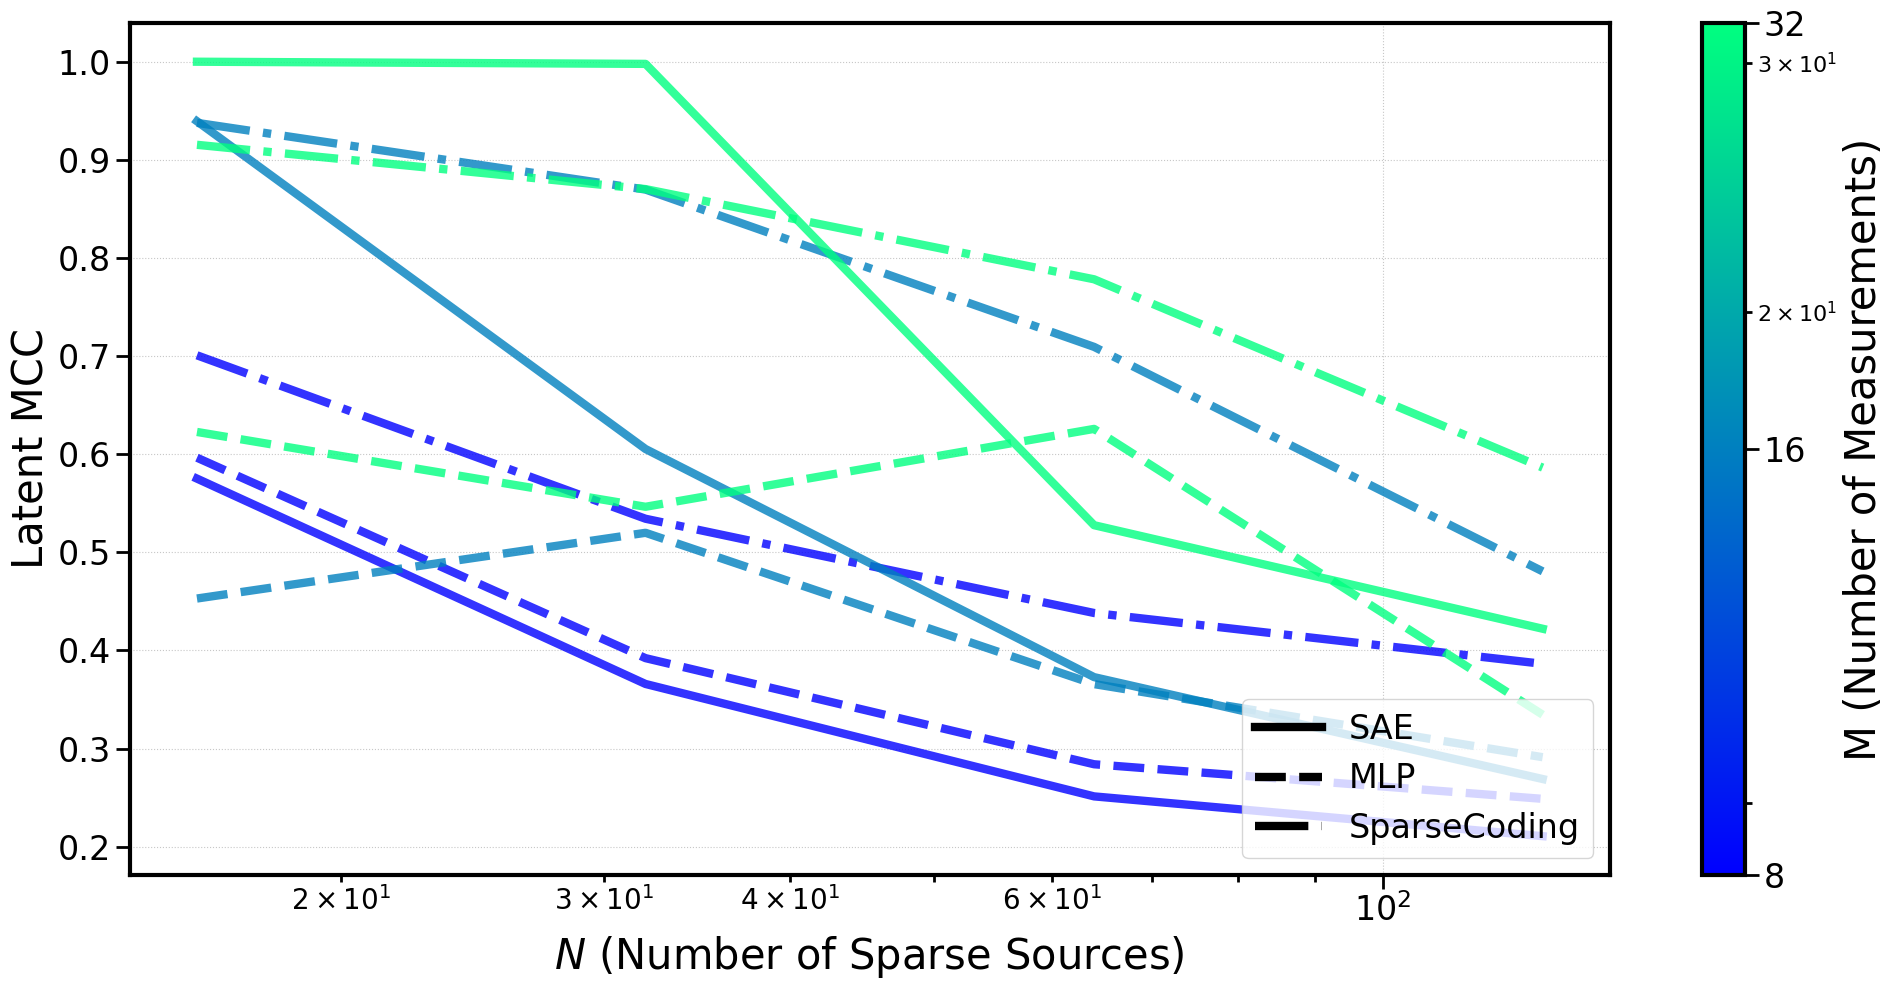

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import json

# Load results
with open('results/scaling_laws_results.json', 'r') as f:
    results = json.load(f)

# Parameters
base_font_size = 24
title_font_size = base_font_size * 1.5
label_font_size = base_font_size * 1.25
legend_font_size = base_font_size
tick_font_size = base_font_size
minor_tick_font_size = tick_font_size - 4

base_line_width = 6
data_line_width = base_line_width
box_line_width = 3
tick_width = 2

# Set up the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Create colormap with log scale
cmap = plt.get_cmap('winter')
M_values = sorted([int(M) for M in results['SAE'].keys()])
norm = LogNorm(vmin=min(M_values), vmax=max(M_values))

# Plot data points and connecting lines
methods = ['SAE', 'MLP', 'SparseCoding']
linestyles = {'SAE': '-', 'MLP': '--', 'SparseCoding': '-.'}

for M in M_values:
    color = cmap(norm(M))
    for method in methods:
        N_values = [item[0] for item in results[method][str(M)]]
        mcc_values = [item[1] for item in results[method][str(M)]]
        
        # Plot lines
        ax.plot(N_values, mcc_values, color=color, linewidth=data_line_width, 
                linestyle=linestyles[method], alpha=0.8, label=f'{method} (M={M})')

# Customize the plot
ax.set_xscale('log')
ax.set_xlabel('$N$ (Number of Sparse Sources)', fontsize=label_font_size)
ax.set_ylabel('Latent MCC', fontsize=label_font_size)
ax.grid(True, linestyle=':', alpha=0.7)

# Set font size and width for tick labels and marks
ax.tick_params(axis='both', which='major', labelsize=tick_font_size, width=tick_width, length=10)
ax.tick_params(axis='both', which='minor', labelsize=minor_tick_font_size, width=tick_width, length=5)

# Make the bounding box thicker
for spine in ax.spines.values():
    spine.set_linewidth(box_line_width)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('M (Number of Measurements)', fontsize=label_font_size)

# Set font size and width for colorbar ticks
cbar.ax.tick_params(which='both', labelsize=minor_tick_font_size-4, width=tick_width, length=5)
cbar.ax.tick_params(which='major', length=10)

# Make colorbar border thicker
cbar.outline.set_linewidth(box_line_width)

# Adjust colorbar ticks to show actual M values
cbar.set_ticks(M_values)
cbar.set_ticklabels(M_values)

# Manually set font size for major ticks (M values)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(tick_font_size)

# Add legend for methods only
handles = [plt.Line2D([0], [0], color='black', linewidth=data_line_width, linestyle=linestyles[method]) for method in methods]
ax.legend(handles, methods, fontsize=legend_font_size, loc='lower right')

# Adjust layout and display
plt.tight_layout()

# Save figure
#plt.savefig('results/figures/scaling_laws_plot.pdf', dpi=300, bbox_inches='tight')

plt.show()

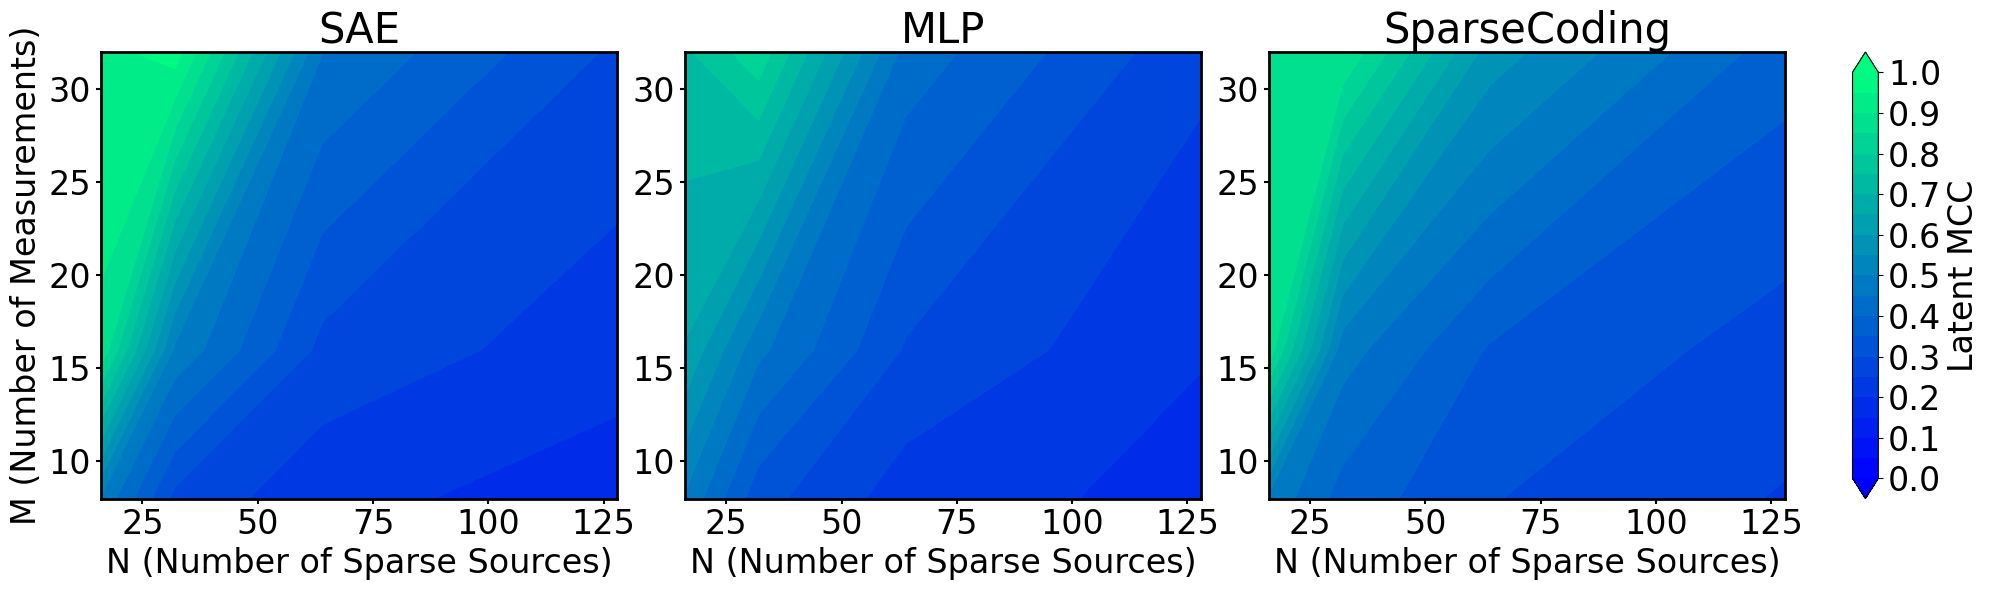

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import json

# Load results
K = 9
with open(f'results/scaling_laws_K_{K}.json', 'r') as f:
    results = json.load(f)

# Parameters
base_font_size = 24
title_font_size = base_font_size * 1.25
label_font_size = base_font_size
tick_font_size = base_font_size
box_line_width = 2
tick_width = 1.5

# Prepare data for contour plots
methods = ['SAE', 'MLP', 'SparseCoding']
N_values = sorted(list(set([item[0] for M in results['SAE'] for item in results['SAE'][M]])))
M_values = sorted([int(M) for M in results['SAE'].keys()])

X, Y = np.meshgrid(N_values, M_values)
Z = {method: [[0 for _ in range(X.shape[1])] for _ in range(X.shape[0])] for method in methods}

for i, M in enumerate(M_values):
    for j, N in enumerate(N_values):
        for method in methods:
            mcc_values = [item[1] for item in results[method][str(M)] if item[0] == N]
            if mcc_values:
                Z[method][i][j] = mcc_values[0]

# Set up the plot
fig = plt.figure(figsize=(20, 6))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 0.05])

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])

# Create a single colorbar for all subplots
levels = np.linspace(0, 1, 21)  # 21 levels to get 20 intervals

for ax, method in zip(axes, methods):
    contour = ax.contourf(X, Y, Z[method], levels=levels, cmap='winter', extend='both')
    ax.set_title(method, fontsize=title_font_size)
    ax.set_xlabel('N (Number of Sparse Sources)', fontsize=label_font_size)
    if ax == axes[0]:
        ax.set_ylabel('M (Number of Measurements)', fontsize=label_font_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size, width=tick_width)
    ax.tick_params(axis='both', which='minor', width=tick_width)
    
    # Make the bounding box thicker
    for spine in ax.spines.values():
        spine.set_linewidth(box_line_width)

# Add a single colorbar for all subplots
cbar = fig.colorbar(contour, cax=cax)
cbar.set_label('Latent MCC', fontsize=label_font_size)
cbar.ax.tick_params(labelsize=tick_font_size)

# Set colorbar ticks and labels
cbar.set_ticks(np.linspace(0, 1, 11))  # 11 ticks from 0 to 1
cbar.set_ticklabels([f'{x:.1f}' for x in np.linspace(0, 1, 11)])  # Format to 2 decimal places

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f'results/figures/scaling_laws_contour_plot_K_{K}.pdf', dpi=300, bbox_inches='tight')

plt.show()